<img src = 'téléchargement.png'>

# Projet 07 du parcours Datascientist

## Implémentez un modèle de scoring 

<img src = "Logo_P7.png">

### Objectifs 

### Plan 

### I.Mise en place 

In [1]:
!pip install missingno

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np

import missingno as msn

import seaborn as sns

import matplotlib.pyplot as plt

import os

from sklearn.preprocessing import LabelEncoder

import gc

from contextlib import contextmanager

import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import auc, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

from threading import Thread
import functools

import warnings
warnings.filterwarnings("ignore")

### II.La donnée brute 

In [4]:
df_test_app = pd.read_csv('./datasets/OC_P7/application_test.csv', sep = ',', index_col = 0)
df_train_app = pd.read_csv('./datasets/OC_P7/application_train.csv', sep = ',', index_col = 0)
df_bureau = pd.read_csv('./datasets/OC_P7/bureau.csv', sep = ',', index_col = 0)
df_bureau_bal = pd.read_csv('./datasets/OC_P7/bureau_balance.csv', sep = ',', index_col = 0)
df_card = pd.read_csv('./datasets/OC_P7/credit_card_balance.csv', sep = ',', index_col = 0)
#df_credit = pd.read_csv('./datasets/OC_P7/HomeCredit_columns_description.csv', on_bad_lines = 'skip', sep = ';')
df_payments = pd.read_csv('./datasets/OC_P7/installments_payments.csv', sep = ',', index_col = 0)
df_cash = pd.read_csv('./datasets/OC_P7/POS_CASH_balance.csv', sep = ',', index_col = False)
df_previous_app = pd.read_csv('./datasets/OC_P7/previous_application.csv', sep = ',', index_col = 0)
df_sample = pd.read_csv('./datasets/OC_P7/sample_submission.csv', sep = ',', index_col = 0)

In [5]:
with open('./datasets/OC_P7/HomeCredit_columns_description.csv') as f:
    print(f)

<_io.TextIOWrapper name='./datasets/OC_P7/HomeCredit_columns_description.csv' mode='r' encoding='cp1252'>


In [6]:
df_credit = pd.read_csv('./datasets/OC_P7/HomeCredit_columns_description.csv', encoding='cp1252', sep = ',', index_col = 0)

In [7]:
print(f'Le fichier du projet P7 df_test_app contient {df_test_app.shape[0]} lignes et {df_test_app.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_train_app contient {df_train_app.shape[0]} lignes et {df_train_app.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_bureau contient {df_bureau.shape[0]} lignes et {df_bureau.shape[1]} colones')
print(f'Le fichier du projet P7 df_bureau_bal contient {df_bureau_bal.shape[0]} lignes et {df_bureau_bal.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_card contient {df_card.shape[0]} lignes et {df_card.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_credit contient {df_credit.shape[0]} lignes et {df_card.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_payments contient {df_payments.shape[0]}) lignes et {df_payments.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_cash contient {df_cash.shape[0]} lignes et {df_cash.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_previous_app {df_previous_app.shape[0]} lignes et {df_previous_app.shape[1]} colonnes')
print(f'Le fichier du projet P7 df_sample {df_sample.shape[0]} lignes et {df_sample.shape[1]} colonnes')

Le fichier du projet P7 df_test_app contient 48744 lignes et 120 colonnes
Le fichier du projet P7 df_train_app contient 307511 lignes et 121 colonnes
Le fichier du projet P7 df_bureau contient 1716428 lignes et 16 colones
Le fichier du projet P7 df_bureau_bal contient 27299925 lignes et 2 colonnes
Le fichier du projet P7 df_card contient 3840312 lignes et 22 colonnes
Le fichier du projet P7 df_credit contient 219 lignes et 22 colonnes
Le fichier du projet P7 df_payments contient 13605401) lignes et 7 colonnes
Le fichier du projet P7 df_cash contient 10001358 lignes et 8 colonnes
Le fichier du projet P7 df_previous_app 1670214 lignes et 36 colonnes
Le fichier du projet P7 df_sample 48744 lignes et 1 colonnes


<img src  = './datasets/OC_P7/home_credit.png'>

### II.1.Jeu de test 

In [8]:
df_test_app.head(5)

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
SK_ID_CURR                                                               
100001             Cash loans           F            N               Y   
100005             Cash loans           M            N               Y   
100013             Cash loans           M            Y               Y   
100028             Cash loans           F            N               Y   
100038             Cash loans           M            Y               N   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100001                 0          135000.0    568800.0      20560.5   
100005                 0           99000.0    222768.0      17370.0   
100013                 0          202500.0    663264.0      69777.0   
100028                 2          315000.0   1575000.0      49018.5   
100038                 1          180000.0    625500.0      32067.0   

            AMT_GOODS_PRICE NAME_TYPE_SUITE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                   ...                    
100001             450000.0   Unaccompanied  ...                0   
100005             180000.0   Unaccompanied  ...                0   
100013             630000.0             NaN  ...                0   
100028            1575000.0   Unaccompanied  ...                0   
100038             625500.0   Unaccompanied  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100001                    0                0                0   
100005                    0                0                0   
100013                    0                0                0   
100028                    0                0                0   
100038                    0                0                0   

            AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                          
100001                             0.0                        0.0   
100005                             0.0                        0.0   
100013                             0.0                        0.0   
100028                             0.0                        0.0   
100038                             NaN                        NaN   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100001                             0.0                        0.0   
100005                             0.0                        0.0   
100013                             0.0                        0.0   
100028                             0.0                        0.0   
100038                             NaN                        NaN   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100001                            0.0                         0.0  
100005                            0.0                         3.0  
100013                            1.0                         4.0  
100028                            0.0                         3.0  
100038                            NaN                         NaN  

[5 rows x 120 columns]

In [9]:
df_test_app_c = df_test_app.reset_index()

In [10]:
df_test_app_c.head(5)

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [11]:
df_test_app_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [12]:
df_test_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 120 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39), object(16)
memory usage: 45.0+ MB


In [13]:
df_test_app.dtypes

NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 120, dtype: object

In [14]:
df_test_app.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)

In [15]:
df_test_app.isna().sum().sum()

1404419

In [16]:
df_test_app.isna().mean()*100

NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
CNT_CHILDREN                   0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     12.409732
AMT_REQ_CREDIT_BUREAU_WEEK    12.409732
AMT_REQ_CREDIT_BUREAU_MON     12.409732
AMT_REQ_CREDIT_BUREAU_QRT     12.409732
AMT_REQ_CREDIT_BUREAU_YEAR    12.409732
Length: 120, dtype: float64

In [17]:
df_test_app.duplicated().sum()

0

In [18]:
df_test_app.nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
CNT_CHILDREN                  11
                              ..
AMT_REQ_CREDIT_BUREAU_DAY      3
AMT_REQ_CREDIT_BUREAU_WEEK     3
AMT_REQ_CREDIT_BUREAU_MON      7
AMT_REQ_CREDIT_BUREAU_QRT      8
AMT_REQ_CREDIT_BUREAU_YEAR    16
Length: 120, dtype: int64

In [19]:
df_test_app.describe().transpose()

count           mean            std      min  \
CNT_CHILDREN                48744.0       0.397054       0.709047      0.0   
AMT_INCOME_TOTAL            48744.0  178431.805855  101522.591536  26941.5   
AMT_CREDIT                  48744.0  516740.435561  365397.004174  45000.0   
AMT_ANNUITY                 48720.0   29426.240209   16016.368315   2295.0   
AMT_GOODS_PRICE             48744.0  462618.840473  336710.215040  45000.0   
...                             ...            ...            ...      ...   
AMT_REQ_CREDIT_BUREAU_DAY   42695.0       0.001803       0.046132      0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  42695.0       0.002787       0.054037      0.0   
AMT_REQ_CREDIT_BUREAU_MON   42695.0       0.009299       0.110924      0.0   
AMT_REQ_CREDIT_BUREAU_QRT   42695.0       0.546902       0.693305      0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  42695.0       1.983769       1.838873      0.0   

                                 25%       50%       75%        max  
CNT_CHILDREN                     0.0       0.0       1.0       20.0  
AMT_INCOME_TOTAL            112500.0  157500.0  225000.0  4410000.0  
AMT_CREDIT                  260640.0  450000.0  675000.0  2245500.0  
AMT_ANNUITY                  17973.0   26199.0   37390.5   180576.0  
AMT_GOODS_PRICE             225000.0  396000.0  630000.0  2245500.0  
...                              ...       ...       ...        ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0        6.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       1.0        7.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       2.0       3.0       17.0  

[104 rows x 8 columns]

<AxesSubplot:>

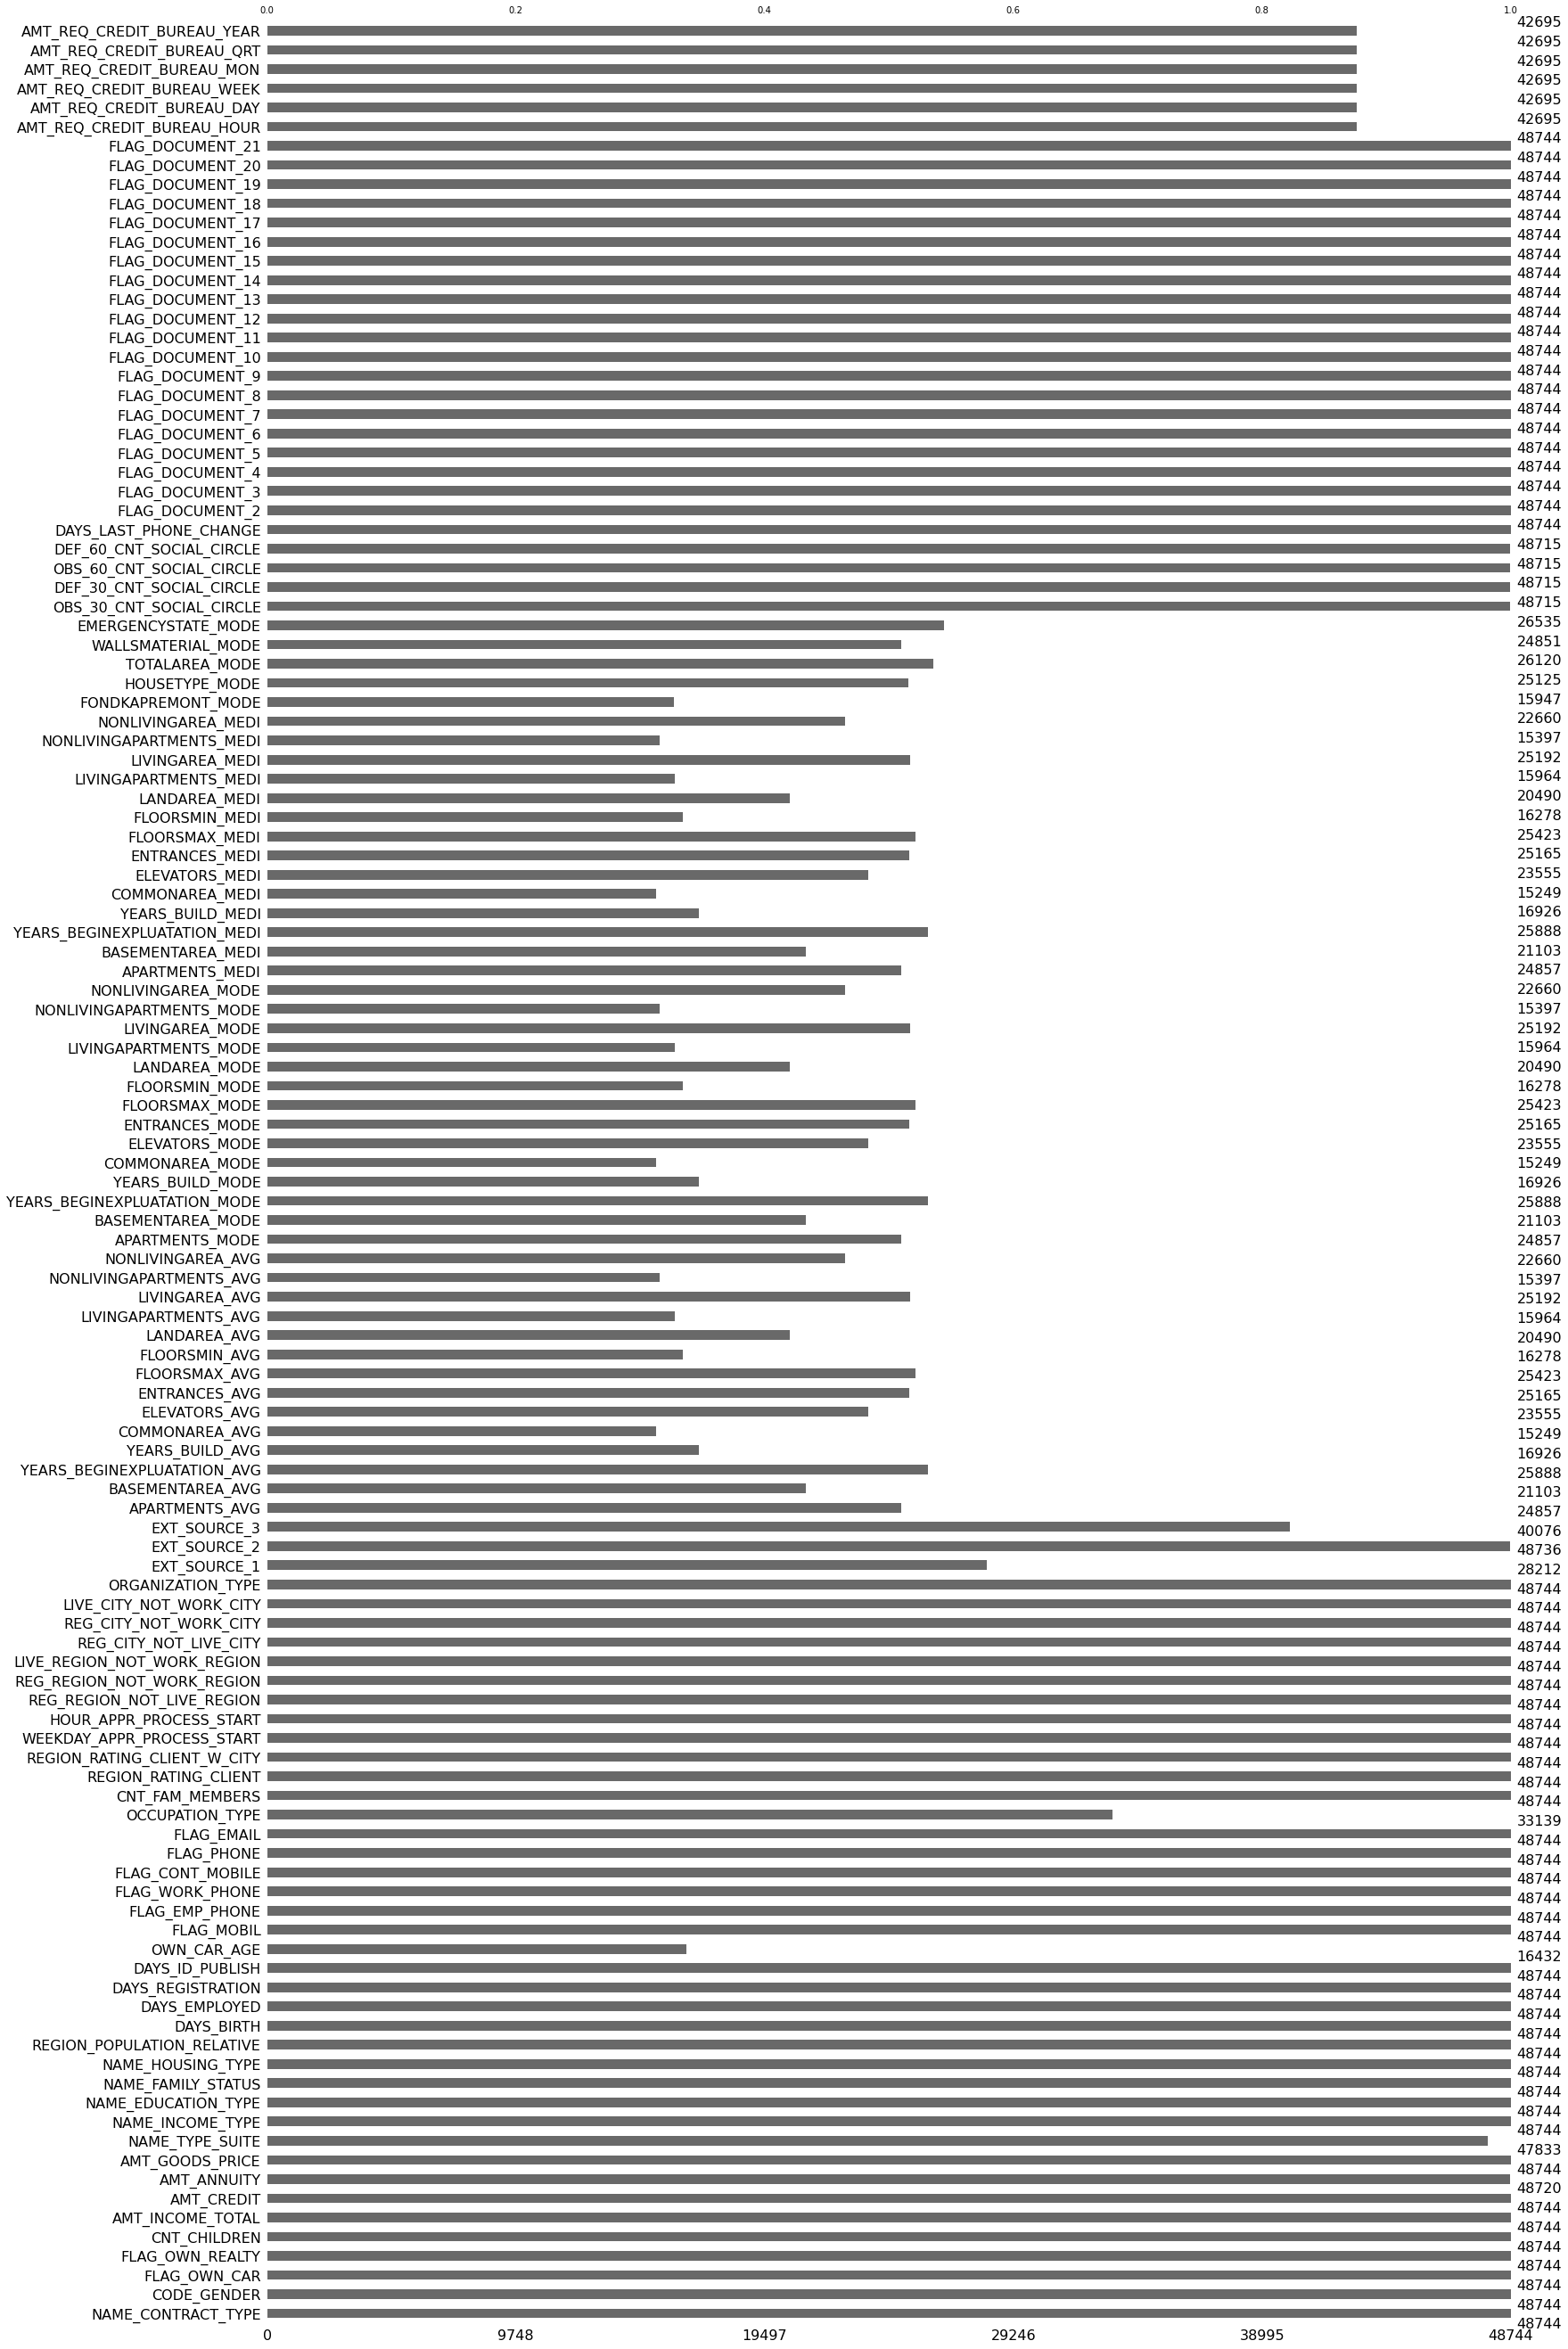

In [20]:
msn.bar(df_test_app)

### II.2.Jeu d'entrainement 

In [21]:
df_train_app.head(5)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18  \
SK_ID_CURR                                ...                    
100002          24700.5         351000.0  ...                0   
100003          35698.5        1129500.0  ...                0   
100004           6750.0         135000.0  ...                0   
100006          29686.5         297000.0  ...                0   
100007          21865.5         513000.0  ...                0   

           FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
SK_ID_CURR                                                      
100002                    0                0                0   
100003                    0                0                0   
100004                    0                0                0   
100006                    0                0                0   
100007                    0                0                0   

           AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
SK_ID_CURR                                                         
100002                            0.0                        0.0   
100003                            0.0                        0.0   
100004                            0.0                        0.0   
100006                            NaN                        NaN   
100007                            0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
SK_ID_CURR                                                          
100002                             0.0                        0.0   
100003                             0.0                        0.0   
100004                             0.0                        0.0   
100006                             NaN                        NaN   
100007                             0.0                        0.0   

            AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
SK_ID_CURR                                                         
100002                            0.0                         1.0  
100003                            0.0                         0.0  
100004                            0.0                         0.0  
100006                            NaN                         NaN  
100007                            0.0                         0.0  

[5 rows x 121 columns]

In [22]:
df_train_app_c = df_train_app.reset_index()

In [23]:
df_train_app_c.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [24]:
df_train_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [25]:
df_train_app.dtypes

TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

In [26]:
df_train_app.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [27]:
df_train_app.isna().sum().sum()

9152465

In [28]:
df_train_app.isna().mean()*100

TARGET                         0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
Length: 121, dtype: float64

In [29]:
df_train_app.duplicated().sum()

0

In [30]:
df_train_app.nunique()

TARGET                         2
NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
                              ..
AMT_REQ_CREDIT_BUREAU_DAY      9
AMT_REQ_CREDIT_BUREAU_WEEK     9
AMT_REQ_CREDIT_BUREAU_MON     24
AMT_REQ_CREDIT_BUREAU_QRT     11
AMT_REQ_CREDIT_BUREAU_YEAR    25
Length: 121, dtype: int64

In [31]:
df_train_app.describe().transpose()

count           mean            std      min  \
TARGET                      307511.0       0.080729       0.272419      0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121      0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279  25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996  45000.0   
AMT_ANNUITY                 307499.0   27108.573909   14493.737315   1615.5   
...                              ...            ...            ...      ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757      0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685      0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002      0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056      0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295      0.0   

                                 25%       50%       75%          max  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
AMT_ANNUITY                  16524.0   24903.0   34596.0     258025.5  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[105 rows x 8 columns]

<AxesSubplot:>

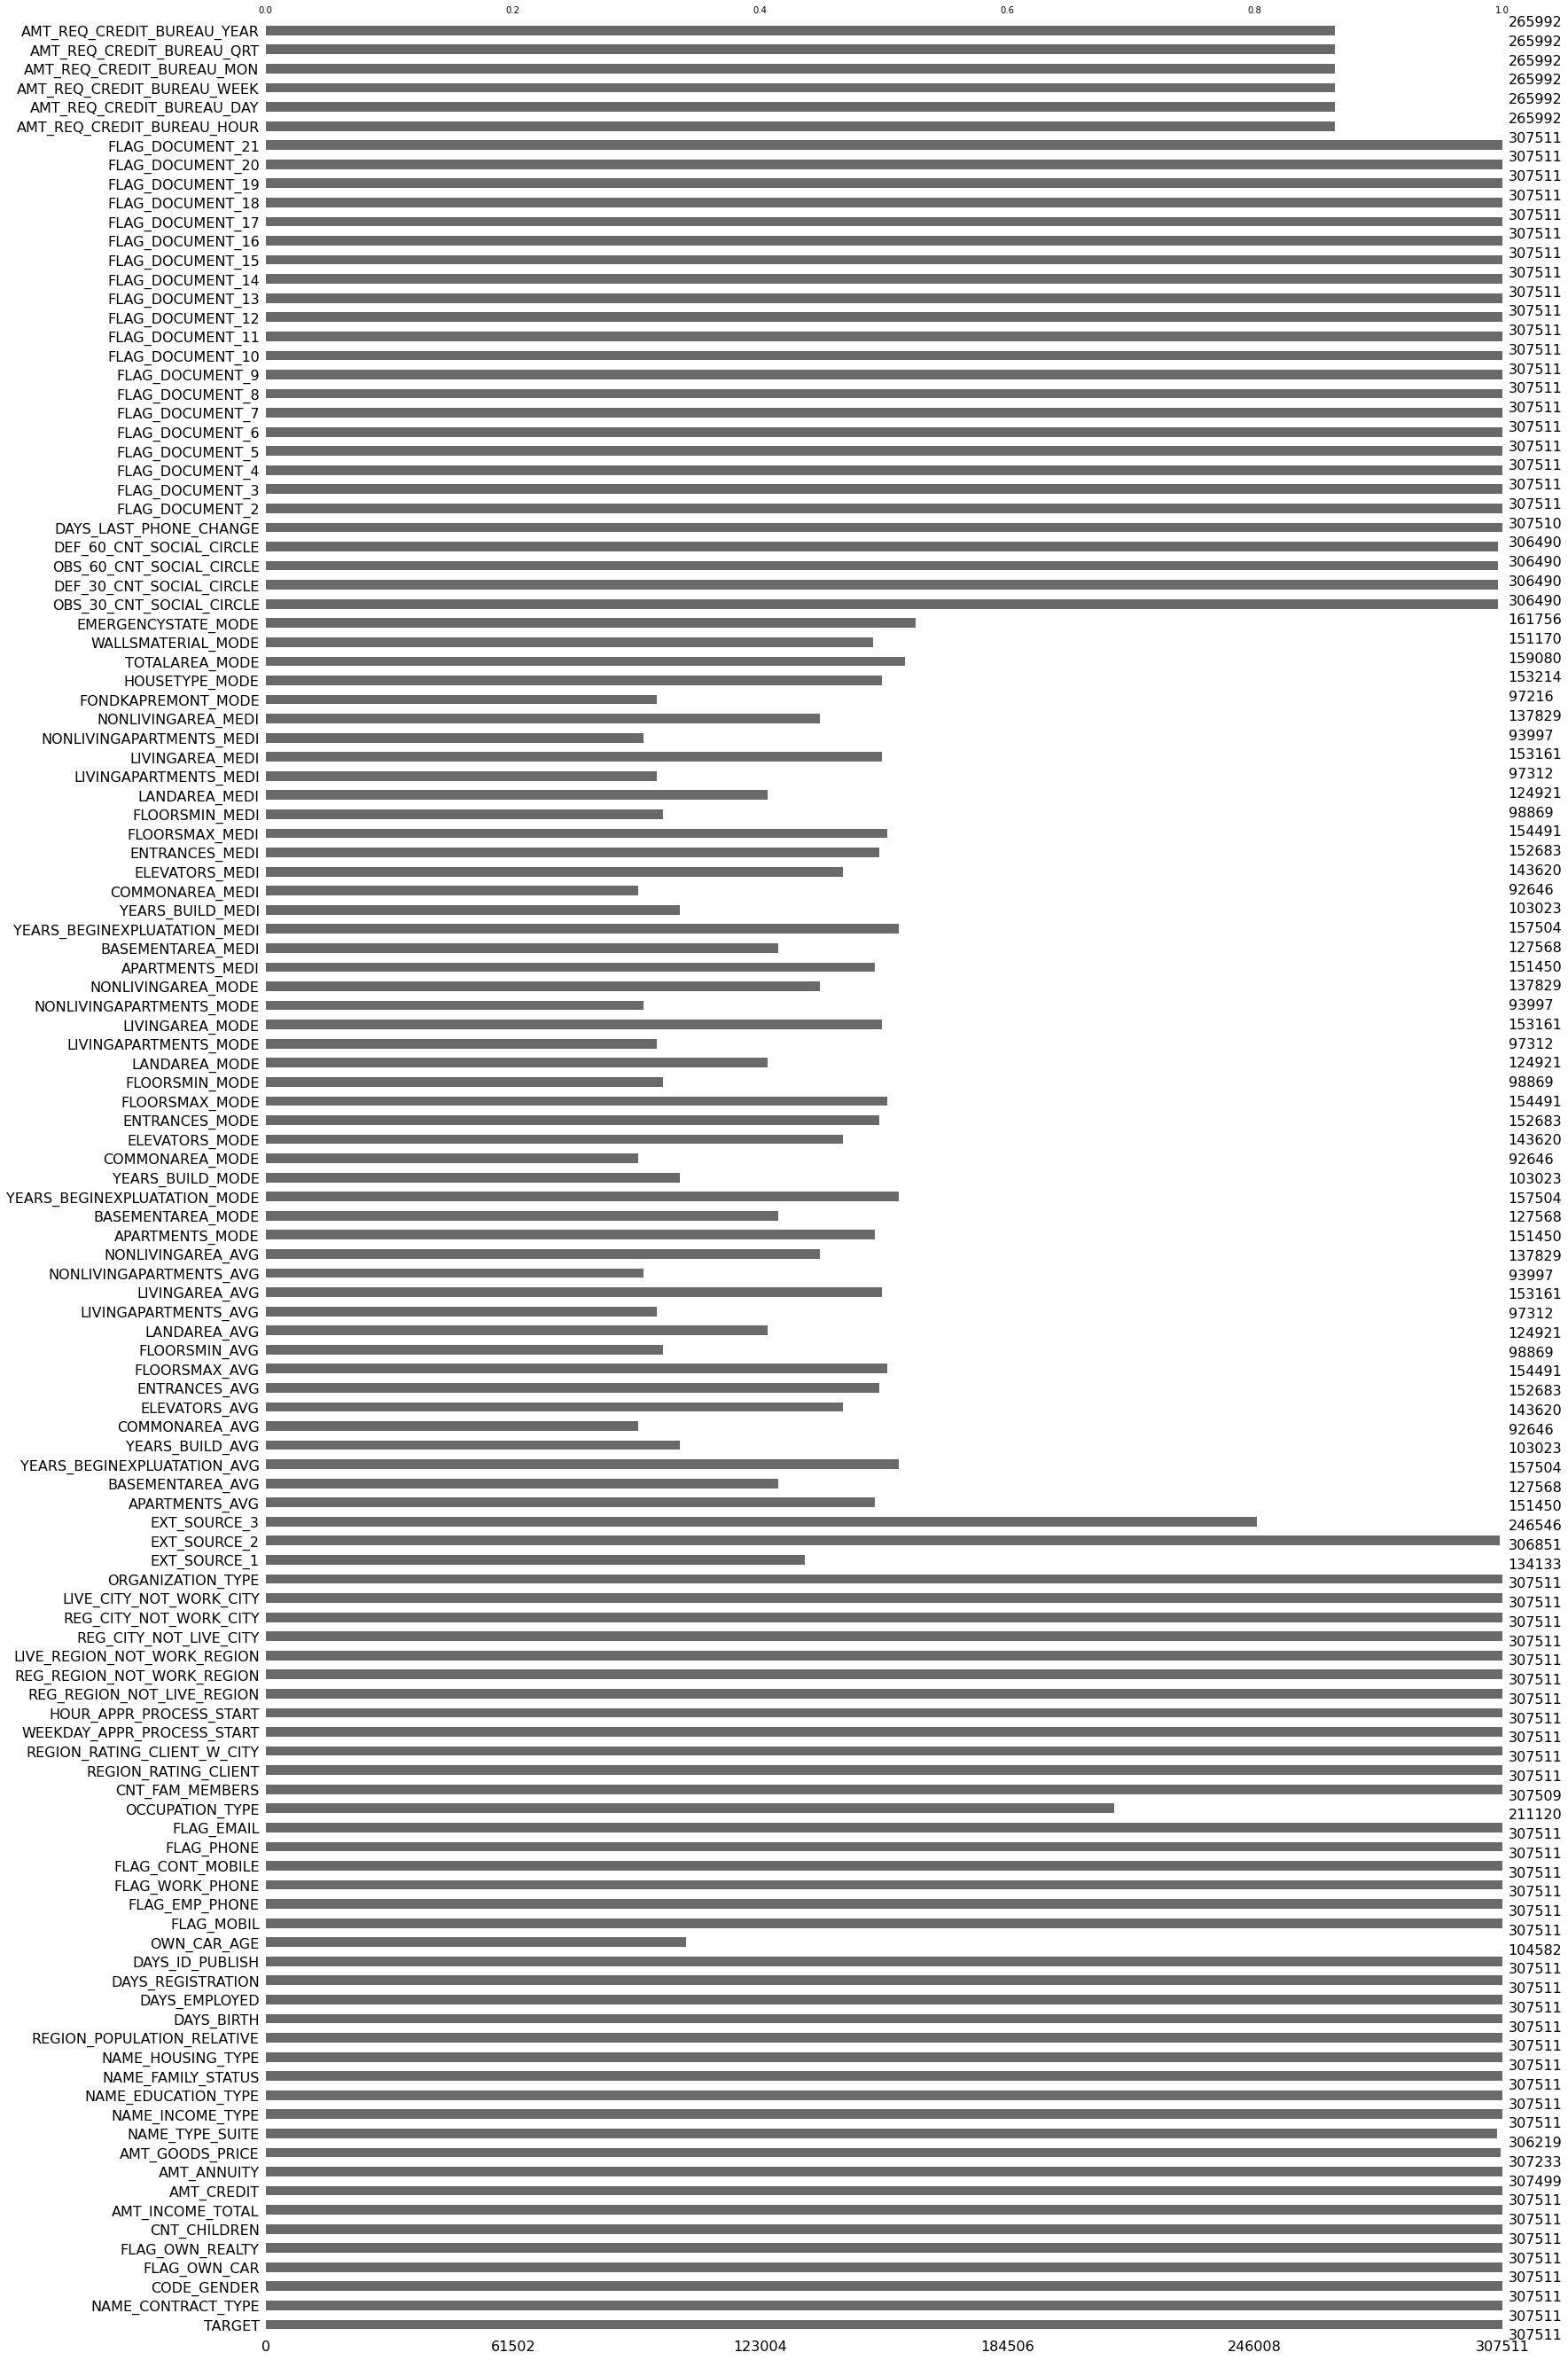

In [32]:
msn.bar(df_train_app)

### II.3.Agence de crédit

In [33]:
df_bureau.head(5)

SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
SK_ID_CURR                                                            
215354           5714462        Closed      currency 1         -497   
215354           5714463        Active      currency 1         -208   
215354           5714464        Active      currency 1         -203   
215354           5714465        Active      currency 1         -203   
215354           5714466        Active      currency 1         -629   

            CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
SK_ID_CURR                                                               
215354                       0               -153.0             -153.0   
215354                       0               1075.0                NaN   
215354                       0                528.0                NaN   
215354                       0                  NaN                NaN   
215354                       0               1197.0                NaN   

            AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
SK_ID_CURR                                                               
215354                         NaN                   0         91323.0   
215354                         NaN                   0        225000.0   
215354                         NaN                   0        464323.5   
215354                         NaN                   0         90000.0   
215354                     77674.5                   0       2700000.0   

            AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
SK_ID_CURR                                                                      
215354                      0.0                   NaN                     0.0   
215354                 171342.0                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   
215354                      NaN                   NaN                     0.0   

                CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
SK_ID_CURR                                                    
215354      Consumer credit                -131          NaN  
215354          Credit card                 -20          NaN  
215354      Consumer credit                 -16          NaN  
215354          Credit card                 -16          NaN  
215354      Consumer credit                 -21          NaN

In [34]:
df_bureau_c = df_bureau.reset_index()

In [35]:
df_bureau_c.head(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [36]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 215354 to 246829
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_BUREAU            int64  
 1   CREDIT_ACTIVE           object 
 2   CREDIT_CURRENCY         object 
 3   DAYS_CREDIT             int64  
 4   CREDIT_DAY_OVERDUE      int64  
 5   DAYS_CREDIT_ENDDATE     float64
 6   DAYS_ENDDATE_FACT       float64
 7   AMT_CREDIT_MAX_OVERDUE  float64
 8   CNT_CREDIT_PROLONG      int64  
 9   AMT_CREDIT_SUM          float64
 10  AMT_CREDIT_SUM_DEBT     float64
 11  AMT_CREDIT_SUM_LIMIT    float64
 12  AMT_CREDIT_SUM_OVERDUE  float64
 13  CREDIT_TYPE             object 
 14  DAYS_CREDIT_UPDATE      int64  
 15  AMT_ANNUITY             float64
dtypes: float64(8), int64(5), object(3)
memory usage: 222.6+ MB


In [37]:
df_bureau_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [38]:
df_bureau.dtypes

SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [39]:
df_bureau.columns

Index(['SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

In [40]:
df_bureau.isna().sum().sum()

3939947

In [41]:
df_bureau.isna().mean()*100

SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64

In [42]:
df_bureau_c.isna().mean()*100

SK_ID_CURR                 0.000000
SK_ID_BUREAU               0.000000
CREDIT_ACTIVE              0.000000
CREDIT_CURRENCY            0.000000
DAYS_CREDIT                0.000000
CREDIT_DAY_OVERDUE         0.000000
DAYS_CREDIT_ENDDATE        6.149573
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_MAX_OVERDUE    65.513264
CNT_CREDIT_PROLONG         0.000000
AMT_CREDIT_SUM             0.000757
AMT_CREDIT_SUM_DEBT       15.011932
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_OVERDUE     0.000000
CREDIT_TYPE                0.000000
DAYS_CREDIT_UPDATE         0.000000
AMT_ANNUITY               71.473490
dtype: float64

In [43]:
df_bureau.duplicated().sum()

0

In [44]:
df_bureau_c.duplicated().sum()

0

In [45]:
df_bureau.nunique()

SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [46]:
df_bureau_c.nunique()

SK_ID_CURR                 305811
SK_ID_BUREAU              1716428
CREDIT_ACTIVE                   4
CREDIT_CURRENCY                 4
DAYS_CREDIT                  2923
CREDIT_DAY_OVERDUE            942
DAYS_CREDIT_ENDDATE         14096
DAYS_ENDDATE_FACT            2917
AMT_CREDIT_MAX_OVERDUE      68251
CNT_CREDIT_PROLONG             10
AMT_CREDIT_SUM             236708
AMT_CREDIT_SUM_DEBT        226537
AMT_CREDIT_SUM_LIMIT        51726
AMT_CREDIT_SUM_OVERDUE       1616
CREDIT_TYPE                    15
DAYS_CREDIT_UPDATE           2982
AMT_ANNUITY                 40321
dtype: int64

In [47]:
df_bureau.describe().transpose()

count          mean           std          min  \
SK_ID_BUREAU            1716428.0  5.924434e+06  5.322657e+05  5000000.000   
DAYS_CREDIT             1716428.0 -1.142108e+03  7.951649e+02    -2922.000   
CREDIT_DAY_OVERDUE      1716428.0  8.181666e-01  3.654443e+01        0.000   
DAYS_CREDIT_ENDDATE     1610875.0  5.105174e+02  4.994220e+03   -42060.000   
DAYS_ENDDATE_FACT       1082775.0 -1.017437e+03  7.140106e+02   -42023.000   
AMT_CREDIT_MAX_OVERDUE   591940.0  3.825418e+03  2.060316e+05        0.000   
CNT_CREDIT_PROLONG      1716428.0  6.410406e-03  9.622391e-02        0.000   
AMT_CREDIT_SUM          1716415.0  3.549946e+05  1.149811e+06        0.000   
AMT_CREDIT_SUM_DEBT     1458759.0  1.370851e+05  6.774011e+05 -4705600.320   
AMT_CREDIT_SUM_LIMIT    1124648.0  6.229515e+03  4.503203e+04  -586406.115   
AMT_CREDIT_SUM_OVERDUE  1716428.0  3.791276e+01  5.937650e+03        0.000   
DAYS_CREDIT_UPDATE      1716428.0 -5.937483e+02  7.207473e+02   -41947.000   
AMT_ANNUITY              489637.0  1.571276e+04  3.258269e+05        0.000   

                               25%        50%         75%           max  
SK_ID_BUREAU            5463953.75  5926303.5  6385681.25  6.843457e+06  
DAYS_CREDIT               -1666.00     -987.0     -474.00  0.000000e+00  
CREDIT_DAY_OVERDUE            0.00        0.0        0.00  2.792000e+03  
DAYS_CREDIT_ENDDATE       -1138.00     -330.0      474.00  3.119900e+04  
DAYS_ENDDATE_FACT         -1489.00     -897.0     -425.00  0.000000e+00  
AMT_CREDIT_MAX_OVERDUE        0.00        0.0        0.00  1.159872e+08  
CNT_CREDIT_PROLONG            0.00        0.0        0.00  9.000000e+00  
AMT_CREDIT_SUM            51300.00   125518.5   315000.00  5.850000e+08  
AMT_CREDIT_SUM_DEBT           0.00        0.0    40153.50  1.701000e+08  
AMT_CREDIT_SUM_LIMIT          0.00        0.0        0.00  4.705600e+06  
AMT_CREDIT_SUM_OVERDUE        0.00        0.0        0.00  3.756681e+06  
DAYS_CREDIT_UPDATE         -908.00     -395.0      -33.00  3.720000e+02  
AMT_ANNUITY                   0.00        0.0    13500.00  1.184534e+08

<AxesSubplot:>

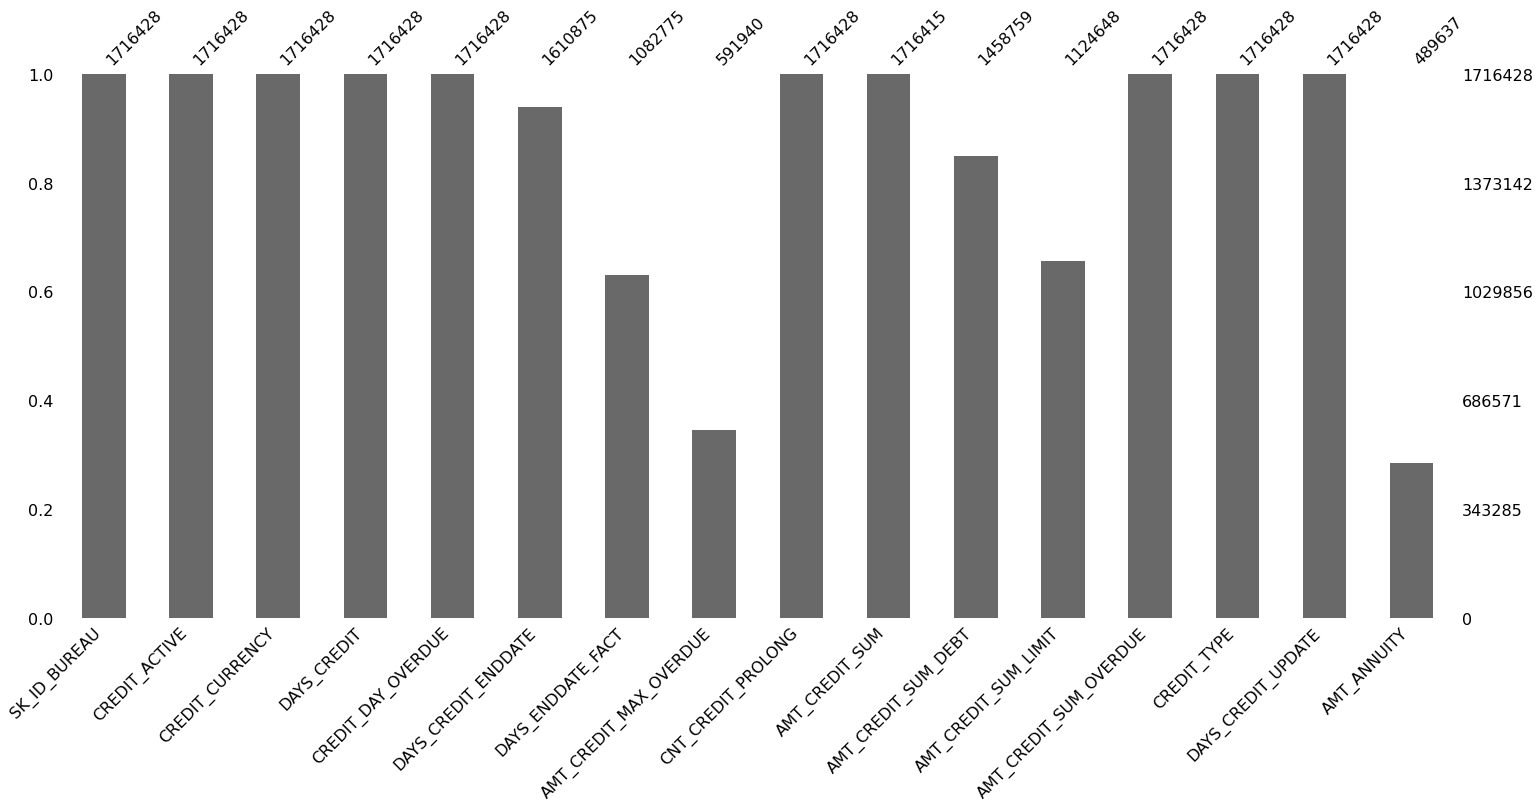

In [48]:
msn.bar(df_bureau)

### II.4.Historique du crédit

In [49]:
df_bureau_bal.head(5)

MONTHS_BALANCE STATUS
SK_ID_BUREAU                       
5715448                    0      C
5715448                   -1      C
5715448                   -2      C
5715448                   -3      C
5715448                   -4      C

In [50]:
df_bureau_bal_c = df_bureau_bal.reset_index()

In [51]:
df_bureau_bal_c.head(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [52]:
df_bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27299925 entries, 5715448 to 5041336
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   MONTHS_BALANCE  int64 
 1   STATUS          object
dtypes: int64(1), object(1)
memory usage: 624.8+ MB


In [53]:
df_bureau_bal_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [54]:
df_bureau_bal.dtypes

MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [55]:
df_bureau_bal.columns

Index(['MONTHS_BALANCE', 'STATUS'], dtype='object')

In [56]:
df_bureau_bal_c.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [57]:
df_bureau_bal.isna().sum().sum()

0

In [58]:
df_bureau_bal.isna().mean()*100

MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

In [59]:
df_bureau_bal_c.isna().mean()*100

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

In [60]:
df_bureau_bal.duplicated().sum()

27299149

In [61]:
df_bureau_bal.duplicated()

SK_ID_BUREAU
5715448    False
5715448    False
5715448    False
5715448    False
5715448    False
           ...  
5041336     True
5041336     True
5041336     True
5041336     True
5041336     True
Length: 27299925, dtype: bool

In [62]:
df_bureau_bal_c.duplicated().sum()

0

In [63]:
df_bureau_bal_c.duplicated()

0           False
1           False
2           False
3           False
4           False
            ...  
27299920    False
27299921    False
27299922    False
27299923    False
27299924    False
Length: 27299925, dtype: bool

In [64]:
df_bureau_bal.nunique()

MONTHS_BALANCE    97
STATUS             8
dtype: int64

In [65]:
df_bureau_bal_c.nunique()

SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64

In [66]:
df_bureau_bal.describe().transpose()

count       mean        std   min   25%   50%   75%  max
MONTHS_BALANCE  27299925.0 -30.741687  23.864509 -96.0 -46.0 -25.0 -11.0  0.0

<AxesSubplot:>

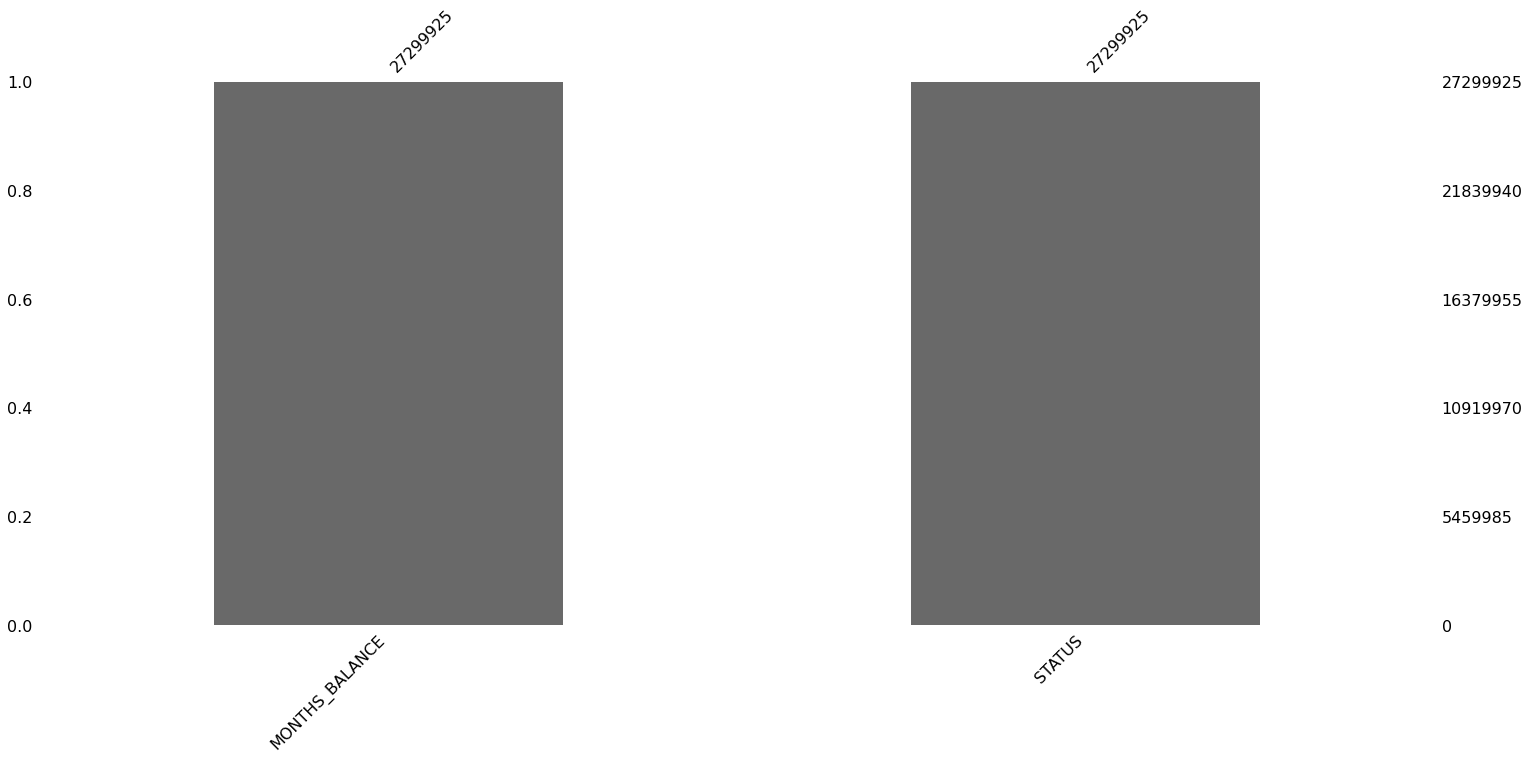

In [67]:
msn.bar(df_bureau_bal)

### II.5.Solde carte de crédit

In [68]:
df_card.head(5)

SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_PREV                                                                     
2562384         378907              -6       56.970                   135000   
2582071         363914              -1    63975.555                    45000   
1740877         371185              -7    31815.225                   450000   
1389973         337855              -4   236572.110                   225000   
1891521         126868              -1   453919.455                   450000   

            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_PREV                                                   
2562384                          0.0                 877.5   
2582071                       2250.0                2250.0   
1740877                          0.0                   0.0   
1389973                       2250.0                2250.0   
1891521                          0.0               11547.0   

            AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
SK_ID_PREV                                                         
2562384                            0.0                     877.5   
2582071                            0.0                       0.0   
1740877                            0.0                       0.0   
1389973                            0.0                       0.0   
1891521                            0.0                   11547.0   

            AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  ...  AMT_RECIVABLE  \
SK_ID_PREV                                                ...                  
2562384                    1700.325               1800.0  ...          0.000   
2582071                    2250.000               2250.0  ...      64875.555   
1740877                    2250.000               2250.0  ...      31460.085   
1389973                   11795.760              11925.0  ...     233048.970   
1891521                   22924.890              27000.0  ...     453919.455   

            AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
SK_ID_PREV                                                   
2562384                    0.000                       0.0   
2582071                64875.555                       1.0   
1740877                31460.085                       0.0   
1389973               233048.970                       1.0   
1891521               453919.455                       0.0   

            CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
SK_ID_PREV                                                     
2562384                        1                         0.0   
2582071                        1                         0.0   
1740877                        0                         0.0   
1389973                        1                         0.0   
1891521                        1                         0.0   

            CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  \
SK_ID_PREV                                                        
2562384                          1.0                       35.0   
2582071                          0.0                       69.0   
1740877                          0.0                       30.0   
1389973                          0.0                       10.0   
1891521                          1.0                      101.0   

            NAME_CONTRACT_STATUS  SK_DPD SK_DPD_DEF  
SK_ID_PREV                                           
2562384                   Active       0          0  
2582071                   Active       0          0  
1740877                   Active       0          0  
1389973                   Active       0          0  
1891521                   Active       0          0  

[5 rows x 22 columns]

In [69]:
df_card_c = df_card.reset_index()

In [70]:
df_card_c.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [71]:
df_card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840312 entries, 2562384 to 2411345
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_CURR                  int64  
 1   MONTHS_BALANCE              int64  
 2   AMT_BALANCE                 float64
 3   AMT_CREDIT_LIMIT_ACTUAL     int64  
 4   AMT_DRAWINGS_ATM_CURRENT    float64
 5   AMT_DRAWINGS_CURRENT        float64
 6   AMT_DRAWINGS_OTHER_CURRENT  float64
 7   AMT_DRAWINGS_POS_CURRENT    float64
 8   AMT_INST_MIN_REGULARITY     float64
 9   AMT_PAYMENT_CURRENT         float64
 10  AMT_PAYMENT_TOTAL_CURRENT   float64
 11  AMT_RECEIVABLE_PRINCIPAL    float64
 12  AMT_RECIVABLE               float64
 13  AMT_TOTAL_RECEIVABLE        float64
 14  CNT_DRAWINGS_ATM_CURRENT    float64
 15  CNT_DRAWINGS_CURRENT        int64  
 16  CNT_DRAWINGS_OTHER_CURRENT  float64
 17  CNT_DRAWINGS_POS_CURRENT    float64
 18  CNT_INSTALMENT_MATURE_CUM   float64
 19  NAME_CONTRACT_S

In [72]:
df_card_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [73]:
df_card.dtypes

SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [74]:
df_card.columns

Index(['SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [75]:
df_card.isna().sum().sum()

5877356

In [76]:
df_card.isna().mean()*100

SK_ID_CURR                     0.000000
MONTHS_BALANCE                 0.000000
AMT_BALANCE                    0.000000
AMT_CREDIT_LIMIT_ACTUAL        0.000000
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_CURRENT           0.000000
AMT_DRAWINGS_OTHER_CURRENT    19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
AMT_INST_MIN_REGULARITY        7.948208
AMT_PAYMENT_CURRENT           19.998063
AMT_PAYMENT_TOTAL_CURRENT      0.000000
AMT_RECEIVABLE_PRINCIPAL       0.000000
AMT_RECIVABLE                  0.000000
AMT_TOTAL_RECEIVABLE           0.000000
CNT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_CURRENT           0.000000
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
NAME_CONTRACT_STATUS           0.000000
SK_DPD                         0.000000
SK_DPD_DEF                     0.000000
dtype: float64

In [77]:
df_card_c.isna().mean()*100

SK_ID_PREV                     0.000000
SK_ID_CURR                     0.000000
MONTHS_BALANCE                 0.000000
AMT_BALANCE                    0.000000
AMT_CREDIT_LIMIT_ACTUAL        0.000000
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_CURRENT           0.000000
AMT_DRAWINGS_OTHER_CURRENT    19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
AMT_INST_MIN_REGULARITY        7.948208
AMT_PAYMENT_CURRENT           19.998063
AMT_PAYMENT_TOTAL_CURRENT      0.000000
AMT_RECEIVABLE_PRINCIPAL       0.000000
AMT_RECIVABLE                  0.000000
AMT_TOTAL_RECEIVABLE           0.000000
CNT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_CURRENT           0.000000
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
NAME_CONTRACT_STATUS           0.000000
SK_DPD                         0.000000
SK_DPD_DEF                     0.000000
dtype: float64

In [78]:
df_card.duplicated().sum()

19

In [79]:
df_card_c.duplicated().sum()

0

In [80]:
df_card.nunique()

SK_ID_CURR                     103558
MONTHS_BALANCE                     96
AMT_BALANCE                   1347904
AMT_CREDIT_LIMIT_ACTUAL           181
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_CURRENT           187005
AMT_DRAWINGS_OTHER_CURRENT       1832
AMT_DRAWINGS_POS_CURRENT       168748
AMT_INST_MIN_REGULARITY        312266
AMT_PAYMENT_CURRENT            163209
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_RECEIVABLE_PRINCIPAL      1195839
AMT_RECIVABLE                 1338878
AMT_TOTAL_RECEIVABLE          1339008
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_CURRENT              129
CNT_DRAWINGS_OTHER_CURRENT         11
CNT_DRAWINGS_POS_CURRENT          133
CNT_INSTALMENT_MATURE_CUM         121
NAME_CONTRACT_STATUS                7
SK_DPD                            917
SK_DPD_DEF                        378
dtype: int64

In [81]:
df_card_c.nunique()

SK_ID_PREV                     104307
SK_ID_CURR                     103558
MONTHS_BALANCE                     96
AMT_BALANCE                   1347904
AMT_CREDIT_LIMIT_ACTUAL           181
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_CURRENT           187005
AMT_DRAWINGS_OTHER_CURRENT       1832
AMT_DRAWINGS_POS_CURRENT       168748
AMT_INST_MIN_REGULARITY        312266
AMT_PAYMENT_CURRENT            163209
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_RECEIVABLE_PRINCIPAL      1195839
AMT_RECIVABLE                 1338878
AMT_TOTAL_RECEIVABLE          1339008
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_CURRENT              129
CNT_DRAWINGS_OTHER_CURRENT         11
CNT_DRAWINGS_POS_CURRENT          133
CNT_INSTALMENT_MATURE_CUM         121
NAME_CONTRACT_STATUS                7
SK_DPD                            917
SK_DPD_DEF                        378
dtype: int64

In [82]:
df_card.describe().transpose()

count           mean            std  \
SK_ID_CURR                  3840312.0  278324.207289  102704.475133   
MONTHS_BALANCE              3840312.0     -34.521921      26.667751   
AMT_BALANCE                 3840312.0   58300.155262  106307.031025   
AMT_CREDIT_LIMIT_ACTUAL     3840312.0  153807.957400  165145.699523   
AMT_DRAWINGS_ATM_CURRENT    3090496.0    5961.324822   28225.688579   
AMT_DRAWINGS_CURRENT        3840312.0    7433.388179   33846.077334   
AMT_DRAWINGS_OTHER_CURRENT  3090496.0     288.169582    8201.989345   
AMT_DRAWINGS_POS_CURRENT    3090496.0    2968.804848   20796.887047   
AMT_INST_MIN_REGULARITY     3535076.0    3540.204129    5600.154122   
AMT_PAYMENT_CURRENT         3072324.0   10280.537702   36078.084953   
AMT_PAYMENT_TOTAL_CURRENT   3840312.0    7588.856739   32005.987768   
AMT_RECEIVABLE_PRINCIPAL    3840312.0   55965.876905  102533.616843   
AMT_RECIVABLE               3840312.0   58088.811177  105965.369908   
AMT_TOTAL_RECEIVABLE        3840312.0   58098.285489  105971.801103   
CNT_DRAWINGS_ATM_CURRENT    3090496.0       0.309449       1.100401   
CNT_DRAWINGS_CURRENT        3840312.0       0.703144       3.190347   
CNT_DRAWINGS_OTHER_CURRENT  3090496.0       0.004812       0.082639   
CNT_DRAWINGS_POS_CURRENT    3090496.0       0.559479       3.240649   
CNT_INSTALMENT_MATURE_CUM   3535076.0      20.825084      20.051494   
SK_DPD                      3840312.0       9.283667      97.515700   
SK_DPD_DEF                  3840312.0       0.331622      21.479231   

                                   min        25%       50%           75%  \
SK_ID_CURR                  100006.000  189517.00  278396.0  367580.00000   
MONTHS_BALANCE                 -96.000     -55.00     -28.0     -11.00000   
AMT_BALANCE                -420250.185       0.00       0.0   89046.68625   
AMT_CREDIT_LIMIT_ACTUAL          0.000   45000.00  112500.0  180000.00000   
AMT_DRAWINGS_ATM_CURRENT     -6827.310       0.00       0.0       0.00000   
AMT_DRAWINGS_CURRENT         -6211.620       0.00       0.0       0.00000   
AMT_DRAWINGS_OTHER_CURRENT       0.000       0.00       0.0       0.00000   
AMT_DRAWINGS_POS_CURRENT         0.000       0.00       0.0       0.00000   
AMT_INST_MIN_REGULARITY          0.000       0.00       0.0    6633.91125   
AMT_PAYMENT_CURRENT              0.000     152.37    2702.7    9000.00000   
AMT_PAYMENT_TOTAL_CURRENT        0.000       0.00       0.0    6750.00000   
AMT_RECEIVABLE_PRINCIPAL   -423305.820       0.00       0.0   85359.24000   
AMT_RECIVABLE              -420250.185       0.00       0.0   88899.49125   
AMT_TOTAL_RECEIVABLE       -420250.185       0.00       0.0   88914.51000   
CNT_DRAWINGS_ATM_CURRENT         0.000       0.00       0.0       0.00000   
CNT_DRAWINGS_CURRENT             0.000       0.00       0.0       0.00000   
CNT_DRAWINGS_OTHER_CURRENT       0.000       0.00       0.0       0.00000   
CNT_DRAWINGS_POS_CURRENT         0.000       0.00       0.0       0.00000   
CNT_INSTALMENT_MATURE_CUM        0.000       4.00      15.0      32.00000   
SK_DPD                           0.000       0.00       0.0       0.00000   
SK_DPD_DEF                       0.000       0.00       0.0       0.00000   

                                    max  
SK_ID_CURR                   456250.000  
MONTHS_BALANCE                   -1.000  
AMT_BALANCE                 1505902.185  
AMT_CREDIT_LIMIT_ACTUAL     1350000.000  
AMT_DRAWINGS_ATM_CURRENT    2115000.000  
AMT_DRAWINGS_CURRENT        2287098.315  
AMT_DRAWINGS_OTHER_CURRENT  1529847.000  
AMT_DRAWINGS_POS_CURRENT    2239274.160  
AMT_INST_MIN_REGULARITY      202882.005  
AMT_PAYMENT_CURRENT         4289207.445  
AMT_PAYMENT_TOTAL_CURRENT   4278315.690  
AMT_RECEIVABLE_PRINCIPAL    1472316.795  
AMT_RECIVABLE               1493338.185  
AMT_TOTAL_RECEIVABLE        1493338.185  
CNT_DRAWINGS_ATM_CURRENT         51.000  
CNT_DRAWINGS_CURRENT            165.000  
CNT_DRAWINGS_OTHER_CURRENT       12.000  
CNT_DRAWINGS_POS_C

<AxesSubplot:>

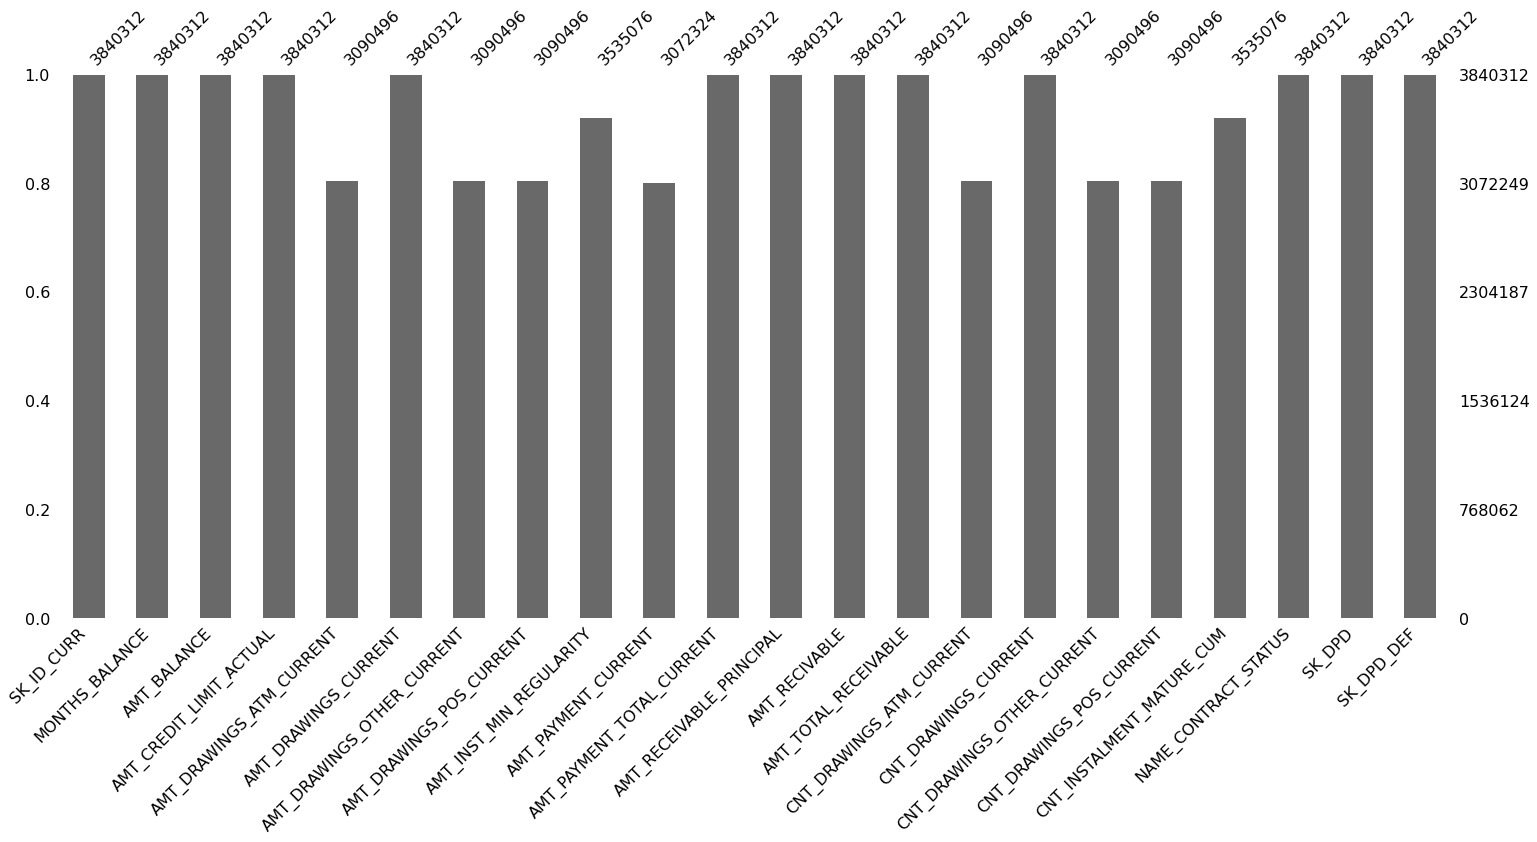

In [83]:
msn.bar(df_card)

### II.6.Description des données 

In [84]:
df_credit.head(5)

Table                 Row  \
1  application_{train|test}.csv          SK_ID_CURR   
2  application_{train|test}.csv              TARGET   
5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
6  application_{train|test}.csv         CODE_GENDER   
7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
1                           ID of loan in our sample     NaN  
2  Target variable (1 - client with payment diffi...     NaN  
5        Identification if loan is cash or revolving     NaN  
6                               Gender of the client     NaN  
7                      Flag if the client owns a car     NaN

In [85]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 1 to 221
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Table        219 non-null    object
 1   Row          219 non-null    object
 2   Description  219 non-null    object
 3   Special      86 non-null     object
dtypes: object(4)
memory usage: 8.6+ KB


In [86]:
df_credit.dtypes

Table          object
Row            object
Description    object
Special        object
dtype: object

In [87]:
df_credit.columns

Index(['Table', 'Row', 'Description', 'Special'], dtype='object')

In [88]:
df_credit.isna().sum().sum()

133

In [89]:
df_credit.isna().mean()*100

Table           0.000000
Row             0.000000
Description     0.000000
Special        60.730594
dtype: float64

In [90]:
df_credit.duplicated().sum()

0

In [91]:
df_credit.nunique()

Table            7
Row            196
Description    163
Special          7
dtype: int64

In [92]:
df_credit.describe().transpose()

count unique                                                top  \
Table         219      7                       application_{train|test}.csv   
Row           219    196                                         SK_ID_CURR   
Description   219    163  Normalized information about building where th...   
Special        86      7                                         normalized   

            freq  
Table        122  
Row            6  
Description   47  
Special       53

<AxesSubplot:>

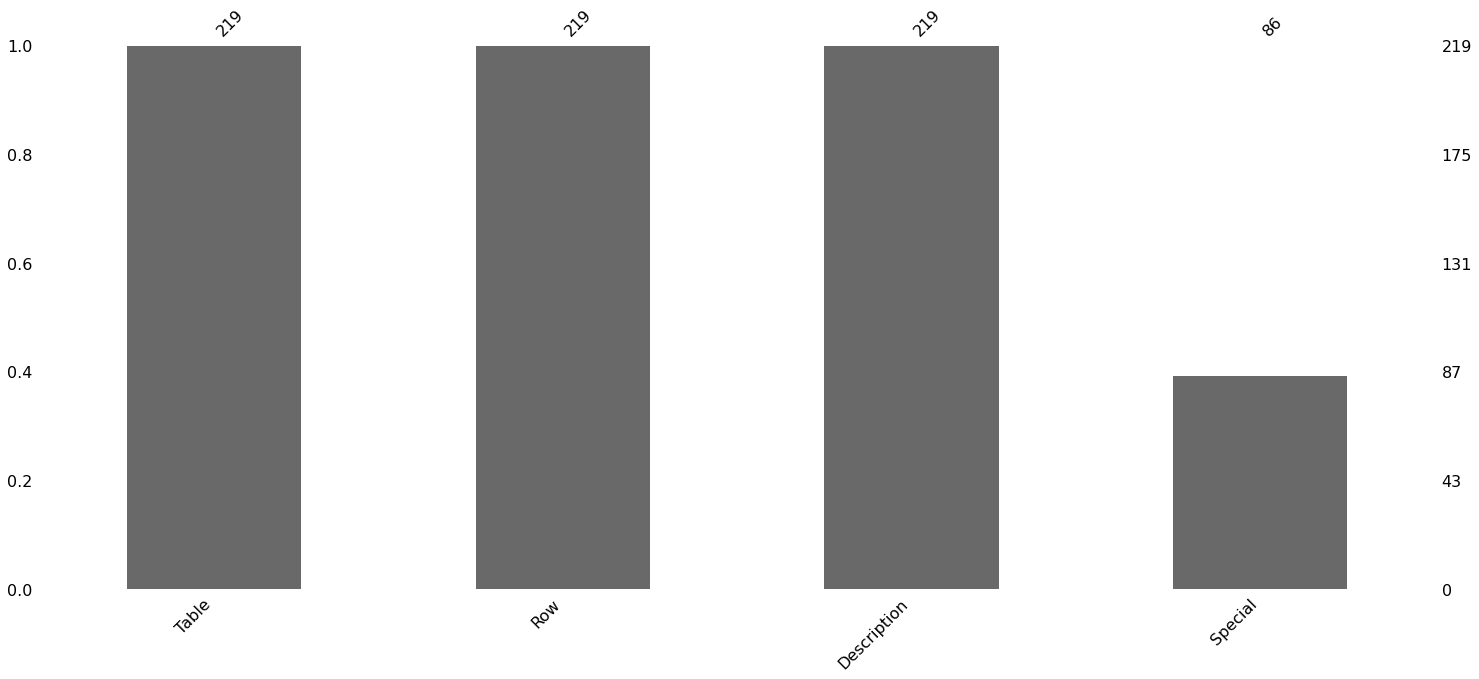

In [93]:
msn.bar(df_credit)

### II.7.Historique remboursement 

In [94]:
df_payments.head(5)

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
SK_ID_PREV                                                              
1054186         161674                     1.0                      6   
1330831         151639                     0.0                     34   
2085231         193053                     2.0                      1   
2452527         199697                     1.0                      3   
2714724         167756                     1.0                      2   

            DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
SK_ID_PREV                                                                    
1054186             -1180.0             -1187.0        6948.360     6948.360  
1330831             -2156.0             -2156.0        1716.525     1716.525  
2085231               -63.0               -63.0       25425.000    25425.000  
2452527             -2418.0             -2426.0       24350.130    24350.130  
2714724             -1383.0             -1366.0        2165.040     2160.585

In [95]:
df_payments_c = df_payments.reset_index()

In [96]:
df_payments_c.head(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [97]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13605401 entries, 1054186 to 2448869
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
dtypes: float64(5), int64(2)
memory usage: 830.4 MB


In [98]:
df_payments_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [99]:
df_payments.dtypes

SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [100]:
df_payments.columns

Index(['SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT'],
      dtype='object')

In [101]:
df_payments.isna().sum().sum()

5810

In [102]:
df_payments.isna().mean()*100

SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.021352
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.021352
dtype: float64

In [103]:
df_payments_c.isna().mean()*100

SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.021352
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.021352
dtype: float64

In [104]:
df_payments.duplicated().sum()

805

In [105]:
df_payments_c.duplicated().sum()

0

In [106]:
df_payments.nunique()

SK_ID_CURR                339587
NUM_INSTALMENT_VERSION        65
NUM_INSTALMENT_NUMBER        277
DAYS_INSTALMENT             2922
DAYS_ENTRY_PAYMENT          3039
AMT_INSTALMENT            902539
AMT_PAYMENT               944235
dtype: int64

In [107]:
df_payments_c.nunique()

SK_ID_PREV                997752
SK_ID_CURR                339587
NUM_INSTALMENT_VERSION        65
NUM_INSTALMENT_NUMBER        277
DAYS_INSTALMENT             2922
DAYS_ENTRY_PAYMENT          3039
AMT_INSTALMENT            902539
AMT_PAYMENT               944235
dtype: int64

In [108]:
df_payments.describe().transpose()

count           mean            std       min  \
SK_ID_CURR              13605401.0  278444.881738  102718.310411  100001.0   
NUM_INSTALMENT_VERSION  13605401.0       0.856637       1.035216       0.0   
NUM_INSTALMENT_NUMBER   13605401.0      18.870896      26.664067       1.0   
DAYS_INSTALMENT         13605401.0   -1042.269992     800.946284   -2922.0   
DAYS_ENTRY_PAYMENT      13602496.0   -1051.113684     800.585883   -4921.0   
AMT_INSTALMENT          13605401.0   17050.906989   50570.254429       0.0   
AMT_PAYMENT             13602496.0   17238.223250   54735.783981       0.0   

                               25%         50%         75%          max  
SK_ID_CURR              189639.000  278685.000  367530.000   456255.000  
NUM_INSTALMENT_VERSION       0.000       1.000       1.000      178.000  
NUM_INSTALMENT_NUMBER        4.000       8.000      19.000      277.000  
DAYS_INSTALMENT          -1654.000    -818.000    -361.000       -1.000  
DAYS_ENTRY_PAYMENT       -1662.000    -827.000    -370.000       -1.000  
AMT_INSTALMENT            4226.085    8884.080   16710.210  3771487.845  
AMT_PAYMENT               3398.265    8125.515   16108.425  3771487.845

<AxesSubplot:>

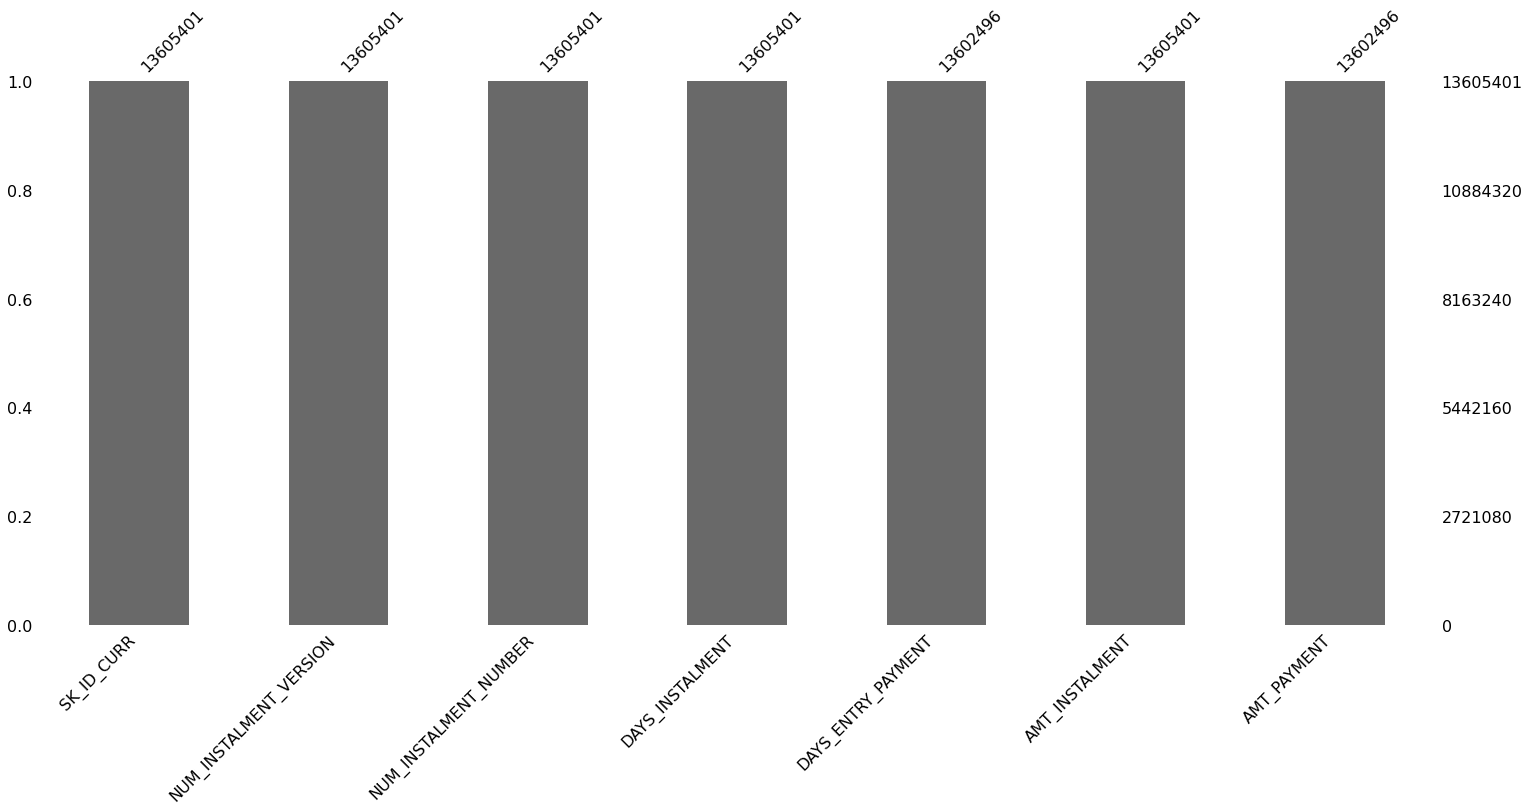

In [109]:
msn.bar(df_payments)

### II.8.Cash balance 

In [110]:
df_cash.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [111]:
df_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [112]:
df_cash.dtypes

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

In [113]:
df_cash.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [114]:
df_cash.isna().sum().sum()

52158

In [115]:
df_cash.isna().mean()*100

SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
CNT_INSTALMENT           0.260675
CNT_INSTALMENT_FUTURE    0.260835
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

In [116]:
df_cash.duplicated().sum()

0

In [117]:
df_cash.nunique()

SK_ID_PREV               936325
SK_ID_CURR               337252
MONTHS_BALANCE               96
CNT_INSTALMENT               73
CNT_INSTALMENT_FUTURE        79
NAME_CONTRACT_STATUS          9
SK_DPD                     3400
SK_DPD_DEF                 2307
dtype: int64

In [118]:
df_cash.describe().transpose()

count          mean            std        min  \
SK_ID_PREV             10001358.0  1.903217e+06  535846.530722  1000001.0   
SK_ID_CURR             10001358.0  2.784039e+05  102763.745090   100001.0   
MONTHS_BALANCE         10001358.0 -3.501259e+01      26.066570      -96.0   
CNT_INSTALMENT          9975287.0  1.708965e+01      11.995056        1.0   
CNT_INSTALMENT_FUTURE   9975271.0  1.048384e+01      11.109058        0.0   
SK_DPD                 10001358.0  1.160693e+01     132.714043        0.0   
SK_DPD_DEF             10001358.0  6.544684e-01      32.762491        0.0   

                             25%        50%        75%        max  
SK_ID_PREV             1434405.0  1896565.0  2368963.0  2843499.0  
SK_ID_CURR              189550.0   278654.0   367429.0   456255.0  
MONTHS_BALANCE             -54.0      -28.0      -13.0       -1.0  
CNT_INSTALMENT              10.0       12.0       24.0       92.0  
CNT_INSTALMENT_FUTURE        3.0        7.0       14.0       85.0  
SK_DPD                       0.0        0.0        0.0     4231.0  
SK_DPD_DEF                   0.0        0.0        0.0     3595.0

<AxesSubplot:>

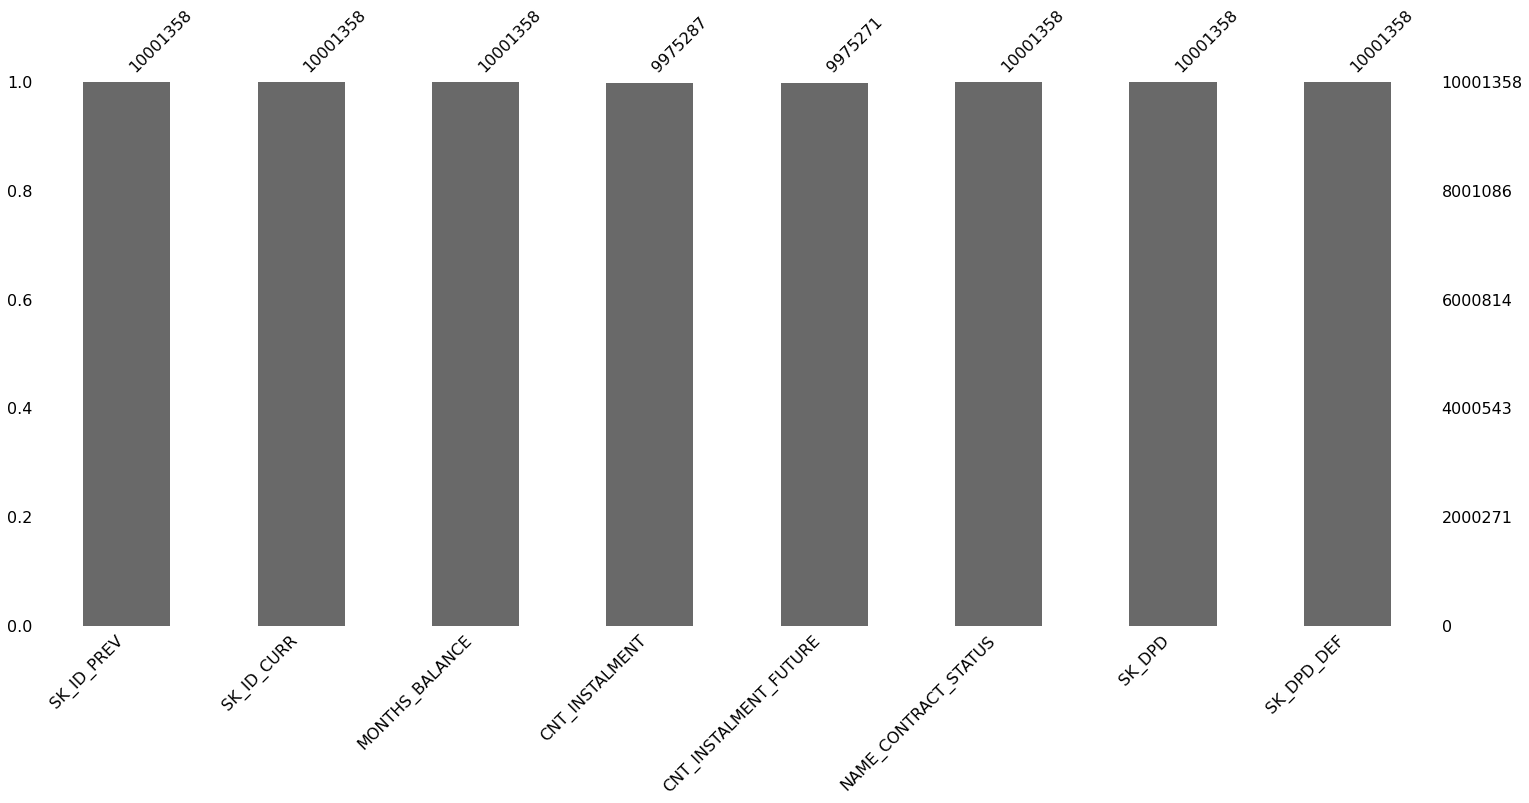

In [119]:
msn.bar(df_cash)

### II.9.Historique demande de prêts

In [120]:
df_previous_app.head(5)

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
SK_ID_PREV                                                                
2030495         271877     Consumer loans     1730.430          17145.0   
2802425         108129         Cash loans    25188.615         607500.0   
2523466         122040         Cash loans    15060.735         112500.0   
2819243         176158         Cash loans    47041.335         450000.0   
1784265         202054         Cash loans    31924.395         337500.0   

            AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
SK_ID_PREV                                                  
2030495        17145.0               0.0          17145.0   
2802425       679671.0               NaN         607500.0   
2523466       136444.5               NaN         112500.0   
2819243       470790.0               NaN         450000.0   
1784265       404055.0               NaN         337500.0   

           WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
SK_ID_PREV                                                       
2030495                      SATURDAY                       15   
2802425                      THURSDAY                       11   
2523466                       TUESDAY                       11   
2819243                        MONDAY                        7   
1784265                      THURSDAY                        9   

           FLAG_LAST_APPL_PER_CONTRACT  ...  NAME_SELLER_INDUSTRY  \
SK_ID_PREV                              ...                         
2030495                              Y  ...          Connectivity   
2802425                              Y  ...                   XNA   
2523466                              Y  ...                   XNA   
2819243                              Y  ...                   XNA   
1784265                              Y  ...                   XNA   

            CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
SK_ID_PREV                                                            
2030495            12.0            middle  POS mobile with interest   
2802425            36.0        low_action          Cash X-Sell: low   
2523466            12.0              high         Cash X-Sell: high   
2819243            12.0            middle       Cash X-Sell: middle   
1784265            24.0              high         Cash Street: high   

           DAYS_FIRST_DRAWING DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  \
SK_ID_PREV                                                                
2030495              365243.0          -42.0                      300.0   
2802425              365243.0         -134.0                      916.0   
2523466              365243.0         -271.0                       59.0   
2819243              365243.0         -482.0                     -152.0   
1784265                   NaN            NaN                        NaN   

           DAYS_LAST_DUE DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
SK_ID_PREV                                                           
2030495            -42.0            -37.0                       0.0  
2802425         365243.0         365243.0                       1.0  
2523466         365243.0         365243.0                       1.0  
2819243           -182.0           -177.0                       1.0  
1784265              NaN              NaN                       NaN  

[5 rows x 36 columns]

In [121]:
df_previous_app_c = df_previous_app.reset_index()

In [122]:
df_previous_app_c.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [123]:
df_previous_app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1670214 entries, 2030495 to 2418762
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1670214 non-null  int64  
 1   NAME_CONTRACT_TYPE           1670214 non-null  object 
 2   AMT_ANNUITY                  1297979 non-null  float64
 3   AMT_APPLICATION              1670214 non-null  float64
 4   AMT_CREDIT                   1670213 non-null  float64
 5   AMT_DOWN_PAYMENT             774370 non-null   float64
 6   AMT_GOODS_PRICE              1284699 non-null  float64
 7   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 8   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 9   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 10  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 11  RATE_DOWN_PAYMENT            774370 non-null   float64
 12  RATE_INTEREST_PRIMARY        5951 no

In [124]:
df_previous_app_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [125]:
df_previous_app.dtypes

SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE                    object
SELLERPLACE_AREA         

In [126]:
df_previous_app.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [127]:
df_previous_app.isna().sum().sum()

11109336

In [128]:
df_previous_app.isna().mean()*100

SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_DOWN_PAYMENT               53.636480
AMT_GOODS_PRICE                23.081773
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              53.636480
RATE_INTEREST_PRIMARY          99.643698
RATE_INTEREST_PRIVILEGED       99.643698
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
DAYS_DECISION                   0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_TYPE_SUITE                49.119754
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYPE               0.000000
CHANNEL_TYPE    

In [129]:
df_previous_app_c.isna().mean()*100

SK_ID_PREV                      0.000000
SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
AMT_ANNUITY                    22.286665
AMT_APPLICATION                 0.000000
AMT_CREDIT                      0.000060
AMT_DOWN_PAYMENT               53.636480
AMT_GOODS_PRICE                23.081773
WEEKDAY_APPR_PROCESS_START      0.000000
HOUR_APPR_PROCESS_START         0.000000
FLAG_LAST_APPL_PER_CONTRACT     0.000000
NFLAG_LAST_APPL_IN_DAY          0.000000
RATE_DOWN_PAYMENT              53.636480
RATE_INTEREST_PRIMARY          99.643698
RATE_INTEREST_PRIVILEGED       99.643698
NAME_CASH_LOAN_PURPOSE          0.000000
NAME_CONTRACT_STATUS            0.000000
DAYS_DECISION                   0.000000
NAME_PAYMENT_TYPE               0.000000
CODE_REJECT_REASON              0.000000
NAME_TYPE_SUITE                49.119754
NAME_CLIENT_TYPE                0.000000
NAME_GOODS_CATEGORY             0.000000
NAME_PORTFOLIO                  0.000000
NAME_PRODUCT_TYP

In [130]:
df_previous_app.duplicated().sum()

56846

In [131]:
df_previous_app_c.duplicated().sum()

0

In [132]:
df_previous_app.nunique()

SK_ID_CURR                     338857
NAME_CONTRACT_TYPE                  4
AMT_ANNUITY                    357959
AMT_APPLICATION                 93885
AMT_CREDIT                      86803
AMT_DOWN_PAYMENT                29278
AMT_GOODS_PRICE                 93885
WEEKDAY_APPR_PROCESS_START          7
HOUR_APPR_PROCESS_START            24
FLAG_LAST_APPL_PER_CONTRACT         2
NFLAG_LAST_APPL_IN_DAY              2
RATE_DOWN_PAYMENT              207033
RATE_INTEREST_PRIMARY             148
RATE_INTEREST_PRIVILEGED           25
NAME_CASH_LOAN_PURPOSE             25
NAME_CONTRACT_STATUS                4
DAYS_DECISION                    2922
NAME_PAYMENT_TYPE                   4
CODE_REJECT_REASON                  9
NAME_TYPE_SUITE                     7
NAME_CLIENT_TYPE                    4
NAME_GOODS_CATEGORY                28
NAME_PORTFOLIO                      5
NAME_PRODUCT_TYPE                   3
CHANNEL_TYPE                        8
SELLERPLACE_AREA                 2097
NAME_SELLER_

In [133]:
df_previous_app_c.nunique()

SK_ID_PREV                     1670214
SK_ID_CURR                      338857
NAME_CONTRACT_TYPE                   4
AMT_ANNUITY                     357959
AMT_APPLICATION                  93885
AMT_CREDIT                       86803
AMT_DOWN_PAYMENT                 29278
AMT_GOODS_PRICE                  93885
WEEKDAY_APPR_PROCESS_START           7
HOUR_APPR_PROCESS_START             24
FLAG_LAST_APPL_PER_CONTRACT          2
NFLAG_LAST_APPL_IN_DAY               2
RATE_DOWN_PAYMENT               207033
RATE_INTEREST_PRIMARY              148
RATE_INTEREST_PRIVILEGED            25
NAME_CASH_LOAN_PURPOSE              25
NAME_CONTRACT_STATUS                 4
DAYS_DECISION                     2922
NAME_PAYMENT_TYPE                    4
CODE_REJECT_REASON                   9
NAME_TYPE_SUITE                      7
NAME_CLIENT_TYPE                     4
NAME_GOODS_CATEGORY                 28
NAME_PORTFOLIO                       5
NAME_PRODUCT_TYPE                    3
CHANNEL_TYPE             

In [134]:
df_previous_app.describe().transpose()

count           mean            std  \
SK_ID_CURR                 1670214.0  278357.174099  102814.823849   
AMT_ANNUITY                1297979.0   15955.120659   14782.137335   
AMT_APPLICATION            1670214.0  175233.860360  292779.762387   
AMT_CREDIT                 1670213.0  196114.021218  318574.616546   
AMT_DOWN_PAYMENT            774370.0    6697.402139   20921.495410   
AMT_GOODS_PRICE            1284699.0  227847.279283  315396.557937   
HOUR_APPR_PROCESS_START    1670214.0      12.484182       3.334028   
NFLAG_LAST_APPL_IN_DAY     1670214.0       0.996468       0.059330   
RATE_DOWN_PAYMENT           774370.0       0.079637       0.107823   
RATE_INTEREST_PRIMARY         5951.0       0.188357       0.087671   
RATE_INTEREST_PRIVILEGED      5951.0       0.773503       0.100879   
DAYS_DECISION              1670214.0    -880.679668     779.099667   
SELLERPLACE_AREA           1670214.0     313.951115    7127.443459   
CNT_PAYMENT                1297984.0      16.054082      14.567288   
DAYS_FIRST_DRAWING          997149.0  342209.855039   88916.115834   
DAYS_FIRST_DUE              997149.0   13826.269337   72444.869708   
DAYS_LAST_DUE_1ST_VERSION   997149.0   33767.774054  106857.034789   
DAYS_LAST_DUE               997149.0   76582.403064  149647.415123   
DAYS_TERMINATION            997149.0   81992.343838  153303.516729   
NFLAG_INSURED_ON_APPROVAL   997149.0       0.332570       0.471134   

                                     min            25%            50%  \
SK_ID_CURR                 100001.000000  189329.000000  278714.500000   
AMT_ANNUITY                     0.000000    6321.780000   11250.000000   
AMT_APPLICATION                 0.000000   18720.000000   71046.000000   
AMT_CREDIT                      0.000000   24160.500000   80541.000000   
AMT_DOWN_PAYMENT               -0.900000       0.000000    1638.000000   
AMT_GOODS_PRICE                 0.000000   50841.000000  112320.000000   
HOUR_APPR_PROCESS_START         0.000000      10.000000      12.000000   
NFLAG_LAST_APPL_IN_DAY          0.000000       1.000000       1.000000   
RATE_DOWN_PAYMENT              -0.000015       0.000000       0.051605   
RATE_INTEREST_PRIMARY           0.034781       0.160716       0.189122   
RATE_INTEREST_PRIVILEGED        0.373150       0.715645       0.835095   
DAYS_DECISION               -2922.000000   -1300.000000    -581.000000   
SELLERPLACE_AREA               -1.000000      -1.000000       3.000000   
CNT_PAYMENT                     0.000000       6.000000      12.000000   
DAYS_FIRST_DRAWING          -2922.000000  365243.000000  365243.000000   
DAYS_FIRST_DUE              -2892.000000   -1628.000000    -831.000000   
DAYS_LAST_DUE_1ST_VERSION   -2801.000000   -1242.000000    -361.000000   
DAYS_LAST_DUE               -2889.000000   -1314.000000    -537.000000   
DAYS_TERMINATION            -2874.000000   -1270.000000    -499.000000   
NFLAG_INSURED_ON_APPROVAL       0.000000       0.000000       0.000000   

                                     75%          max  
SK_ID_CURR                 367514.000000   456255.000  
AMT_ANNUITY                 20658.420000   418058.145  
AMT_APPLICATION            180360.000000  6905160.000  
AMT_CREDIT                 216418.500000  6905160.000  
AMT_DOWN_PAYMENT             7740.000000  3060045.000  
AMT_GOODS_PRICE            234000.000000  6905160.000  
HOUR_APPR_PROCESS_START        15.000000       23.000  
NFLAG_LAST_APPL_IN_DAY          1.000000        1.000  
RATE_DOWN_PAYMENT               0.108909        1.000  
RATE_INTEREST_PRIMARY           0.193330        1.000  
RATE_INTEREST_PRIVILEGED        0.852537        1.000  
DAYS_DECISION                -280.000000       -1.000  
SELLERPLACE_AREA               82.000000  4000000.000  
CNT_PAYMENT                    24.000000       84.000  
DAYS_FIRST_DRAWING         365243.000000   365243.000  
DAYS_FIRST_DUE               -411.000000   365243.000  
DAYS_LAST_DUE_1ST_VERSION     129.000000   365243.000

<AxesSubplot:>

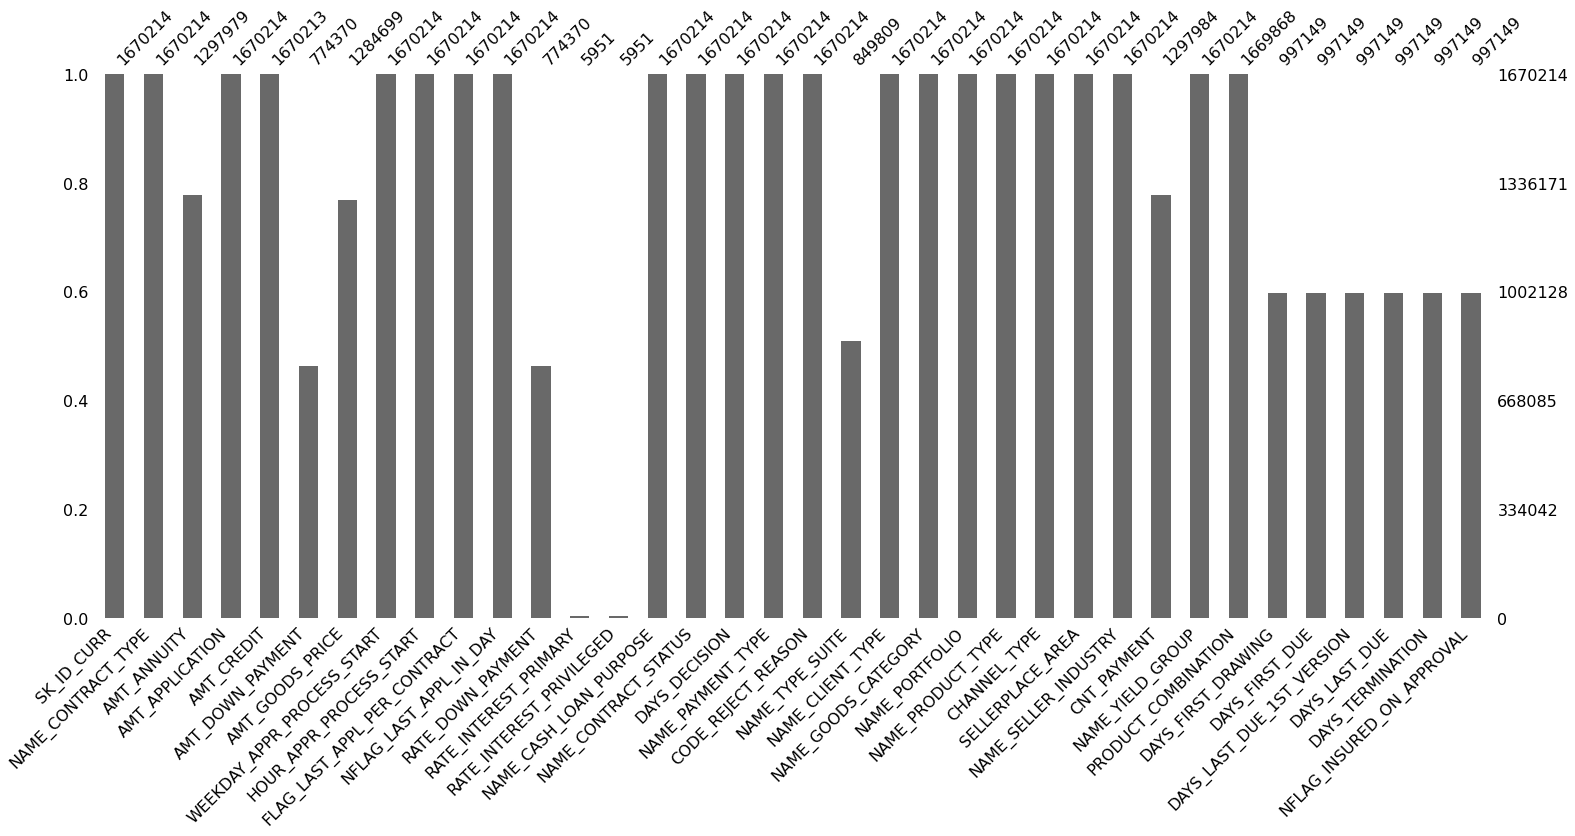

In [135]:
msn.bar(df_previous_app)

### II.10.Sample submission 

In [136]:
df_sample.head(5)

TARGET
SK_ID_CURR        
100001         0.5
100005         0.5
100013         0.5
100028         0.5
100038         0.5

In [137]:
df_sample_c = df_sample.reset_index()

In [138]:
df_sample_c.head(5)

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [139]:
df_sample_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


In [140]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TARGET  48744 non-null  float64
dtypes: float64(1)
memory usage: 761.6 KB


In [141]:
df_sample.dtypes

TARGET    float64
dtype: object

In [142]:
df_sample.columns

Index(['TARGET'], dtype='object')

In [143]:
df_sample.isna().sum().sum()

0

In [144]:
df_sample.isna().mean()*100

TARGET    0.0
dtype: float64

In [145]:
df_sample_c.isna().mean()*100

SK_ID_CURR    0.0
TARGET        0.0
dtype: float64

In [146]:
df_sample.duplicated().sum()

48743

In [147]:
df_sample_c.duplicated().sum()

0

In [148]:
df_sample.nunique()

TARGET    1
dtype: int64

In [149]:
df_sample_c.nunique()

SK_ID_CURR    48744
TARGET            1
dtype: int64

In [150]:
df_sample.describe().transpose()

count  mean  std  min  25%  50%  75%  max
TARGET  48744.0   0.5  0.0  0.5  0.5  0.5  0.5  0.5

In [151]:
df_sample_c.describe().transpose()

count          mean            std       min        25%  \
SK_ID_CURR  48744.0  277796.67635  103169.547296  100001.0  188557.75   
TARGET      48744.0       0.50000       0.000000       0.5       0.50   

                 50%       75%       max  
SK_ID_CURR  277549.0  367555.5  456250.0  
TARGET           0.5       0.5       0.5

<AxesSubplot:>

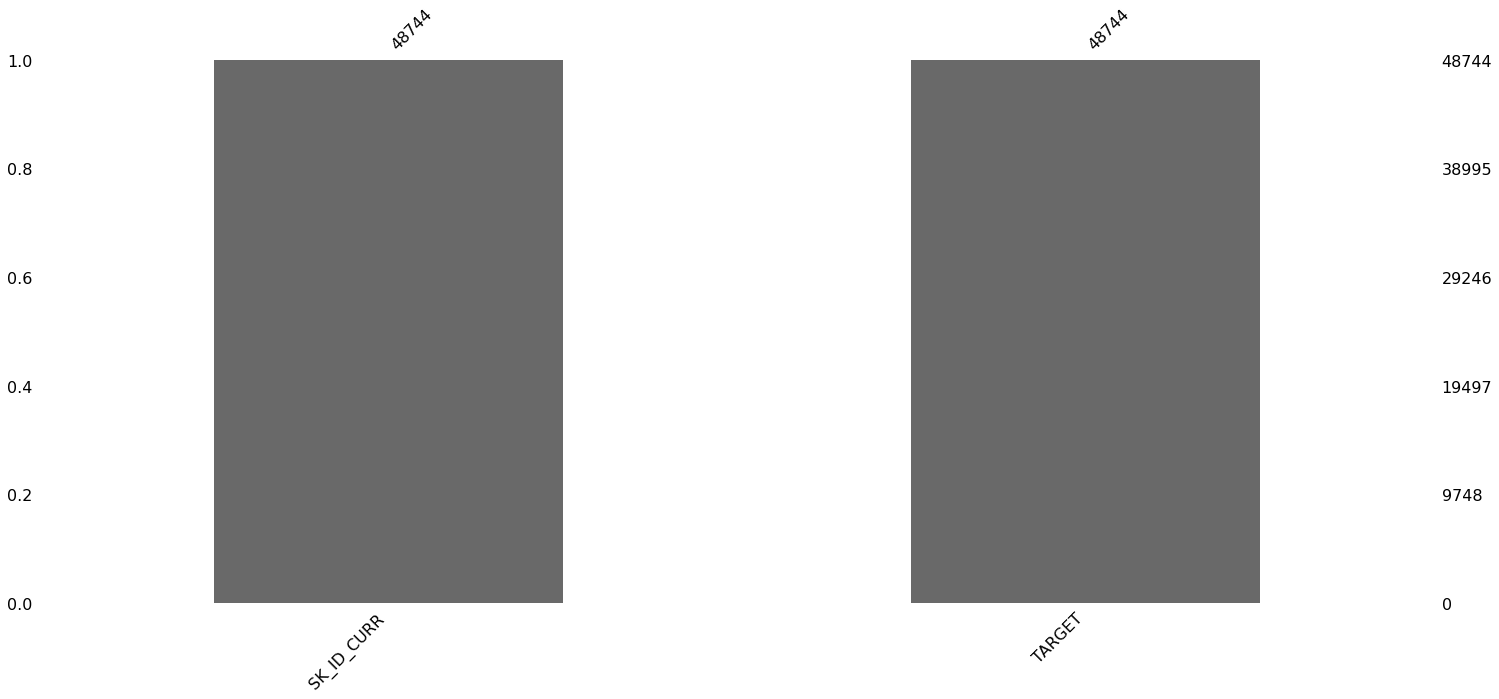

In [152]:
msn.bar(df_sample_c)

In [153]:
#.reset_index()

In [154]:
#test = df_sample.reset_index()

In [155]:
#test.columns

In [156]:
#test.head(5)

In [157]:
#testa = test.set_index("SK_ID_CURR", inplace = True)

In [158]:
#testa.columns

In [159]:
#test.set_index("SK_ID_CURR")

In [160]:
#testa.shape

### III.Exploration des données 

In [161]:
#Lister les fichiers disponibles
print(os.listdir("./datasets/OC_P7"))

['.ipynb_checkpoints', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'home_credit.png', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [162]:
#Données d'entrainement
app_train = pd.read_csv('./datasets/OC_P7/application_train.csv')
print("Format des données d'entrainement (nombre de lignes, nombre de colonnes):", app_train.shape)
app_train.head(5)

Format des données d'entrainement (nombre de lignes, nombre de colonnes): (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [163]:
#Données de test
app_test = pd.read_csv('./datasets/OC_P7/application_test.csv')
print("Format des données de test (nombre de lignes, nombre de colonnes):", app_test.shape)
app_test.head(5)

Format des données de test (nombre de lignes, nombre de colonnes): (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

### III.1.Analyse de la distribution de la colonne 'TARGET'

In [164]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [165]:
app_train['TARGET'].value_counts(normalize = True)*100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

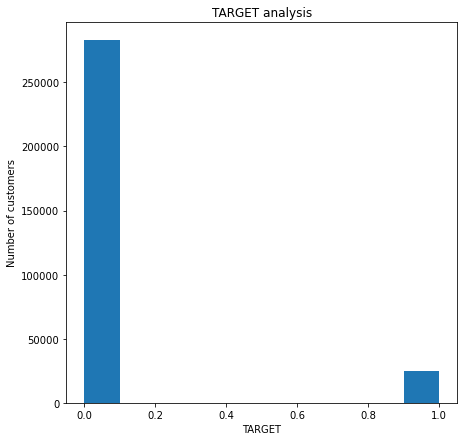

In [166]:
plt.figure(figsize = (7, 7))
plt.hist(app_train['TARGET'].astype(int))
plt.title('TARGET analysis')
plt.xlabel('TARGET')
plt.ylabel('Number of customers')
plt.show()

### III.2.Analyse des valeurs manquantes 

In [167]:
#Fonction pour calculer le nombre de valeurs manquantes par colonne
def missing_values_table(df):
        #Nombre total de valeurs manquantes
        mis_val = df.isnull().sum()
        
        #Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #Création d'un dataframe avec les résultats de calcule
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        #Renomer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        #Trier le tableau par valeurs décroissantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        #Affichage du sommaire d'informations
        print ("Votre dataframe est composé de " + str(df.shape[1]) + " columns.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes qui comportent des valeurs manquantes." + "columns.\n"
              "Le pourcentage de variables avec des valeurs manquantes est de: " + str(round((mis_val_table_ren_columns.shape[0]/df.shape[1])*100, 2)) +"%")
        
        #Retourner un dataframe avec des informations sur les valeurs manquantes
        return mis_val_table_ren_columns

In [168]:
#Statistiques sur les valeurs manquantes
missing_values = missing_values_table(app_train)
missing_values.head(20)

Votre dataframe est composé de 122 columns.
Il y a 67 colonnes qui comportent des valeurs manquantes.columns.
Le pourcentage de variables avec des valeurs manquantes est de: 54.92%


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

### III.3.Types des colonnes 

In [169]:
#Nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [170]:
#Nombre de type unique pour chaque colonne
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### III.4.Encodage des variables catégorielles 

In [171]:
#Création du modèle label encoder
le = LabelEncoder()
le_count = 0

#Itération sur les colonnes
for col in app_train:
    if app_train[col].dtype == 'object':
        #Si 2 ou moins de variables catégorielles uniques
        if len(list(app_train[col].unique())) <= 2:
            #Entrainement sur le jeu de données Train
            le.fit(app_train[col])
            #Transformation des deux jeux de données entrainement (Train) et Test
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            #Garder un historique du nombre de colonnes ayant subi le procéssus de label encoding
            le_count += 1
            
print('%d colonnes ont subi le procéssus du label encoding.' % le_count)

3 colonnes ont subi le procéssus du label encoding.


In [172]:
#Création du modèle de one hot encoder
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Format du jeu de donnée d'entrainement (nombre de lignes, nombre de colonnes): ", app_train.shape)
print("Format du jeu de donnée Test (nombre de lignes, nombre de colonnes): ", app_test.shape)

Format du jeu de donnée d'entrainement (nombre de lignes, nombre de colonnes):  (307511, 243)
Format du jeu de donnée Test (nombre de lignes, nombre de colonnes):  (48744, 239)


### III.5.Alignement des données d'entrainement et de test 

In [173]:
#Lorsque nous effectuons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les dataframes sur les colonnes et non sur les lignes 

train_labels = app_train['TARGET']

#Alignez les données d’entrainement et de test, ne conservez que les colonnes présentes dans les deux jeux de données
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Remettre la variable 'Target'
app_train['TARGET'] = train_labels

print("Format du jeu de donnée d'entrainement (nombre de lignes, nombre de colonnes): ", app_train.shape)
print("Format du jeu de donnée Test (nombre de lignes, nombre de colonnes): ", app_test.shape)

Format du jeu de donnée d'entrainement (nombre de lignes, nombre de colonnes):  (307511, 240)
Format du jeu de donnée Test (nombre de lignes, nombre de colonnes):  (48744, 239)


### III.6.Analyse et Gestion des valeurs aberrantes 

In [174]:
#Pour voir ces valeurs en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [175]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

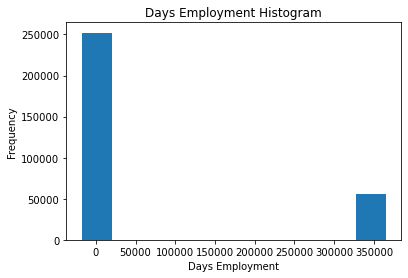

In [176]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [177]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


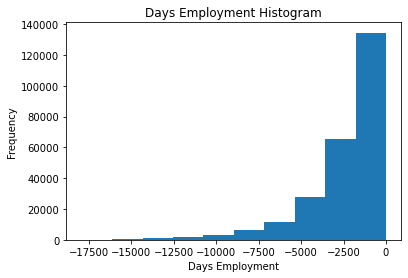

In [178]:
#Création d'une colonne étiquette des anamolies
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

#Remplacer les anomalies par des nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');

plt.xlabel('Days Employment');

In [179]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### III.7.Etude des Corrélations 

### III.7.1.Corrélation de toutes les variables entre-elles 

In [180]:
#Corrélation avec la 'Target'
correlations = app_train.corr()['TARGET'].sort_values()

#Affichage des correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### III.7.2.Effet de l'âge sur le remboursement des prêts 

In [181]:
#Trouver la corrélation des jours en valeurs positives depuis la naissance et la cible
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

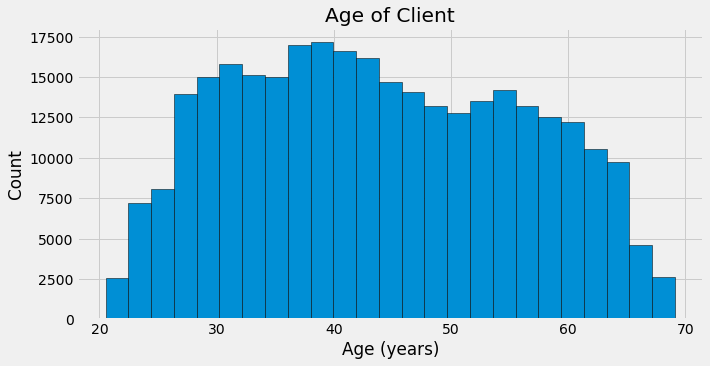

In [182]:
#Définir le style du plot
plt.style.use('fivethirtyeight')

#Tracer la répartition des âges en années
plt.figure(figsize=(10,5))
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

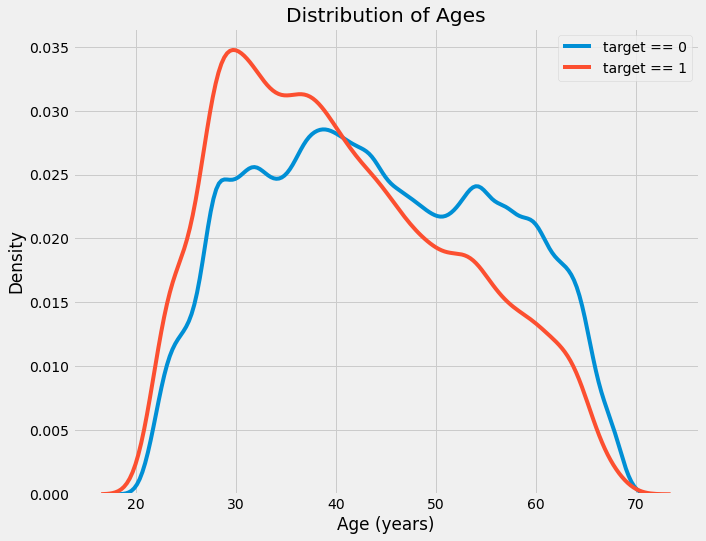

In [183]:
plt.figure(figsize = (10, 8))

#Tracé KDE pour les prêts remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

#Tracé KDE pour les prêts non remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

#Label du plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

plt.legend()
plt.show()

In [184]:
#Mettre les informations sur l'âge dans un jeu de données distinct
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

#Faire un polynome les données sur l'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(5)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]

In [185]:
#Groupage
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

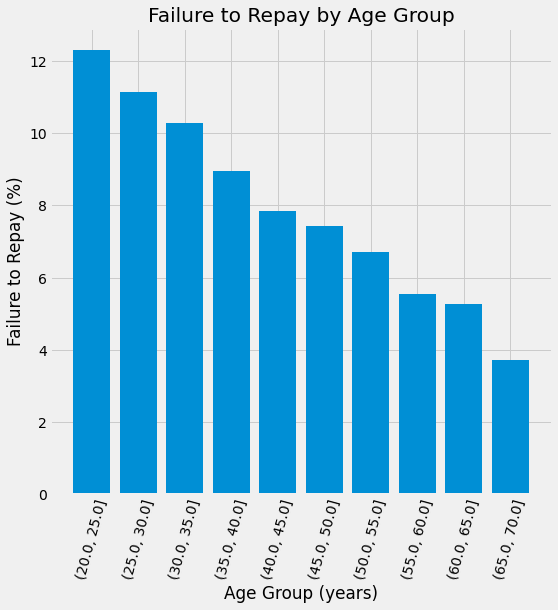

In [186]:
plt.figure(figsize = (8, 8))

#Représenter graphiquement les groupes d’âge et la moyenne de la cible sous forme de graphique à barres
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

#Labele de plot
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### III.7.3.Sources extérieures 

In [187]:
#Extraire les variables EXT_SOURCE et afficher les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

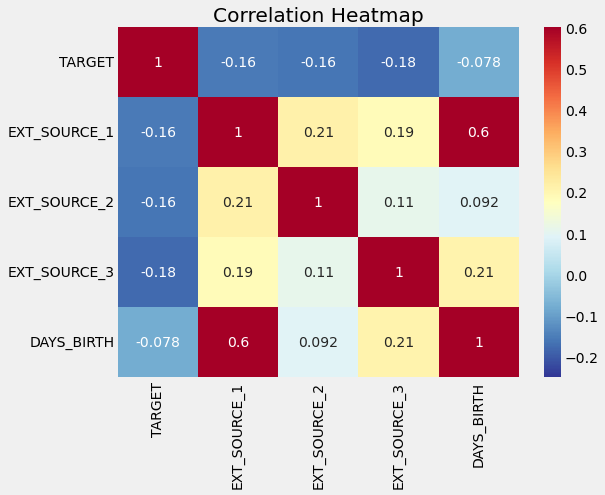

In [188]:
plt.figure(figsize = (8, 6))

#Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

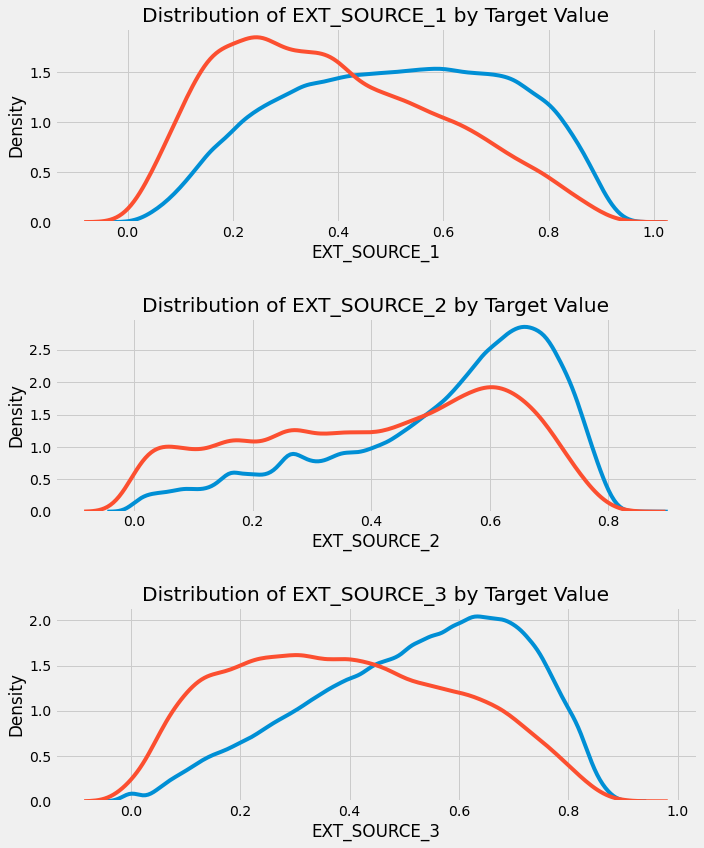

In [189]:
plt.figure(figsize = (10, 12))

#Itération
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    #Création d'un sous groupe pour chaque source de données
    plt.subplot(3, 1, i + 1)
    #Plot des prêts remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    #Plot des prêts non remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    #Label des plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### III.7.4.Pairs Plot 

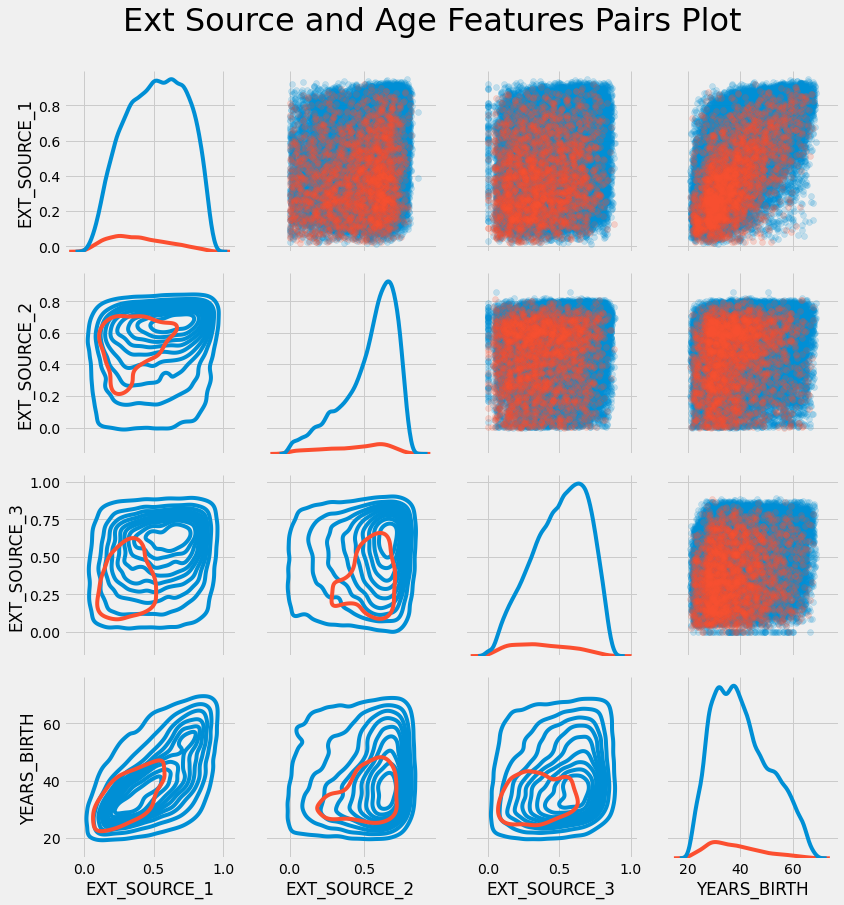

In [190]:
#Copier les données pour le plot
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

#Ajouter l’âge du client en années
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

#Supprimer les valeurs na et limiter aux 100000 premières lignes
plot_data = plot_data.dropna().loc[:100000, :]

#Fonction pour calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

#Créer l’objet pairgrid
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

#Mettre le scatter plot en haut
grid.map_upper(plt.scatter, alpha = 0.2)

#Mettre l'histogramme en diagonal
grid.map_diag(sns.kdeplot)

#Mettre le density plot en bas
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

### IV.Feature Engineering 

### IV.1.Import des fonctions 

### IV.1.1.Import des fonctions originales et modifiées 

In [191]:
@contextmanager
def timer(title):
    '''
    Cette fonction permet de calculer le temps d’exécution d’une fonction.
    Utilisé avec la balise « avec('indiquez ici votre titre'): »
    '''
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [192]:
def one_hot_encoder(df, nan_as_category = True):
    '''
    Cette fonction exécute un onn hot encoder sur les données dont le dtype est 'object' 
    en utilisant la fonction "get_dummies" de Pandas
    '''
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [193]:
def application_train_test(num_rows = None, nan_as_category = False, train=True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans les jeux de données 'application_train.csv' et 'application_test.csv'
    La première étape consiste à fusionner les deux fichiers.
    Les valeurs catégorielles sont encodées par one hot encoder.
    Les valeurs aberrantes sont traitées.
    Enfin, il crée de nouvelles fonctionnalités simples.
    Sortie : données prétraitées au format Dataframe
    '''
    df = pd.read_csv('./datasets/OC_P7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./datasets/OC_P7/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index(drop=True)
    
    print(f'df shape: {df.shape}')

    #Facultatif : Supprimer 4 applications avec XNA 'CODE_GENDER' (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    #Caractéristiques catégorielles avec codage binaire (0 ou 1; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    #Caractéristiques catégorielles avec one hot encoder
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    #Valeurs NaN pour la variable 'DAYS_EMPLOYED': 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    #Quelques nouvelles fonctionnalités simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    #del test_df
    gc.collect()
    return df

In [194]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans les jeux de données 'bureau.csv' et 'bureau_balance.csv' et retournent 
    les données au format dataframe.
    Après avoir appliqué one hot encoder sur les catégories,
    la fonction effectue diverses opérations d’agrégation.
    Le choix du type d’agrégation a été sélectionné, pour chaque variable,
    par le développeur afin de maximiser le score final lors de l’utilisation 
    le modèle d’apprentissage automatique
    '''
    bureau = pd.read_csv('./datasets/OC_P7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./datasets/OC_P7/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    #Bureau balance: effectue une agrégation aggregations et une fusion avec 'bureau.csv'
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    #Valeurs numériques de 'Bureau' et 'bureau_balance' 
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    #Valeurs catégorielles de 'Bureau' et 'bureau_balance' 
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    #Bureau: Active credits - utilisation de l'agrégation numérique
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    #Bureau: Closed credits - utilisation de l'agrégation numérique
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [195]:
def previous_applications(num_rows = None, nan_as_category = True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans le jeu de données 'previous_applications.csv' et retournent 
    les données au format dataframe.
    Après avoir appliqué un one hot encoder sur les catégories,
    la fonction effectue diverses opérations d’agrégation.
    Le choix du type d’agrégation a été sélectionné, pour chaque variable,
    par le développeur afin de maximiser le score final lors de l’utilisation 
    le modèle d’apprentissage automatique
    '''
    prev = pd.read_csv('./datasets/OC_P7/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    #Valeurs en jours 365.243 -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    #Ajouter une fonctionnalité: valeur demandée / valeur reçue en pourcentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    #Applications précédentes des valeurs numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    #Applications précédentes des valeurs catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    #Applications précédentes: approvées - valeurs numériques
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    #Applications précédentes: refusées Applications - valeurs numériques
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [196]:
def pos_cash(num_rows = None, nan_as_category = True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans le jeu de données 'POS_CASH_balance.csv' et retournent 
    les données au format dataframe.
    Après avoir appliqué un one hot encoder sur les catégories,
    la fonction effectue diverses opérations d’agrégation.
    Le choix du type d’agrégation a été sélectionné, pour chaque variable,
    par le développeur afin de maximiser le score final lors de l’utilisation 
    le modèle d’apprentissage automatique
    '''
    pos = pd.read_csv('./datasets/OC_P7/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    #Valeurs
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    #Calcule de pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [197]:
def installments_payments(num_rows = None, nan_as_category = True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans le jeu de données 'installments_payments.csv' et retournent 
    les données au format dataframe.
    Après avoir appliqué un one hot encoder sur les catégories,
    la fonction effectue diverses opérations d’agrégation.
    Le choix du type d’agrégation a été sélectionné, pour chaque variable,
    par le développeur afin de maximiser le score final lors de l’utilisation 
    le modèle d’apprentissage automatique
    '''
    ins = pd.read_csv('./datasets/OC_P7/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Pourcentage et différence payés pour chaque versement (montant payé et valeur des versements)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Jours en retard et jours avant l’échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    #Caractéristiques: application d'agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    #Calcule des comptes de versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [198]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    '''
    Cette fonction importe et effectue le prétraitement des données 
    contenus dans le jeu de données 'credit_card_balance.csv' et retournent 
    les données au format dataframe.
    Après avoir appliqué un one hot encoder sur les catégories,
    la fonction effectue diverses opérations d’agrégation.
    Le choix du type d’agrégation a été sélectionné, pour chaque variable,
    par le développeur afin de maximiser le score final lors de l’utilisation 
    le modèle d’apprentissage automatique
    '''
    cc = pd.read_csv('./datasets/OC_P7/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    #Agrégations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    #Calcule des lignes de carte de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [199]:
def dfImportAndPreprocessing(
    debug = False,
    train = True,
    pInfinite = False,
    pMissing = False,
    optiLGBMC = False,
    memoryOpt = False):
    
    '''
    Cette fonction importe et effectue le prétraitement des données contenues 
    dans les différents fichiers csv du projet.
    En entrée: Aucune donnée à transmettre, ils sont chargés à partir du dossier «  », 
    présent dans le dossier actif.
    La fonction permet également d’effectuer diverses options d’optimisation:
     - Traitement des valeurs manquantes
     - Traitement de valeurs infinies
     - Correction d’erreur si utilisation du modèle LightGBM
     - Optimisation de la mémoire utilisée par le dataframe en optimisant 
     les dtypes de chaque colonne
    '''
    
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows=num_rows, train=train)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    if pInfinite:
        with timer("Processing of infinite values"):
            df = replaceInf(df)
            gc.collect()
    if pMissing:
        with timer("Processing of missing values"):
            #df = replaceNan(df)
            df = pd.concat([df[['TARGET']],replaceNan(df.drop('TARGET', axis=1))], axis=1)
            gc.collect()
    if optiLGBMC:
        with timer("Data Optimisation for LGBMClassifier"):
            import re
            df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    if memoryOpt:
        with timer("Memory Optimisation"):
            df = memOptimization(df)
    return df

### IV.1.2.Import des fonctions maison 

In [200]:
def replaceInf(data, replaceValue=np.nan):
    '''
    Remplace les valeurs "np.inf" contenues dans 
    le jeu de données <data> communiquée en entrée et 
    les remplace par la valeur <replaceValue> 
    également communiqué en tant qu’entrée.
    Renvoie le jeu de données modifiée <data>.
    '''
    nbInf = data.isin([np.inf, -np.inf]).sum().sum()
    print(f'{nbInf} infinite values detected.')
    if nbInf > 0:
        print(f'These values will be replaced by {replaceValue}')
        return data.replace([np.inf, -np.inf], replaceValue)
    else:
        return data

In [201]:
def replaceNan(data, strategy = "median"):
    '''
    Remplace les valeurs "np.nan" contenues dans 
    le jeu de données <data> donné en entrée et 
    les remplace via la fonction "SimpleImputer" 
    selon le <strategy> 
    également communiqué en tant qu’entrée.
    Renvoie le dataframe <data> modifié.
    '''
    from sklearn.impute import SimpleImputer
    nbNaN = data.isnull().sum().sum()
    print(f'{nbNaN} NaN values detected.')
    if nbNaN > 0:
        print(f'Missing values will be replaced by the {strategy} of each column.')
        imp = SimpleImputer(missing_values=np.NaN,
                        strategy=strategy)
        return pd.DataFrame(imp.fit_transform(data),
                            columns=data.columns,
                            index=data.index)
    else:
        return data

In [202]:
def memOptimization(data):
    '''
    This function optimizes the dtype 
    of the columns of the Pandas dataframe
    given as input by using 
    the dtype using the least amount of 
    memory as possible.
    Input: A Pandas dataframe
    Output: The optimized Pandas dataframe
    Cette fonction optimise le dtype 
    des colonnes du dataframe
    donné en entrée en utilisant 
    le dtype utilisant la plus petite quantité de 
    mémoire autant que possible.
    Entrée : un dataframe
    Sortie : un dataframe optimisé
    '''
    print('Détail du DataFrame avant optimisation :')
    print(data.info())
    num_cols = data.select_dtypes('number').columns
    data[num_cols] = data[num_cols].apply(lambda x: pd.to_numeric(x, downcast='integer'))
    print('Détail du DataFrame après optimisation :')
    print(data.info())
    return data

In [203]:
def dateNow(carJoin='_'):
    '''
    Returns the current date in the format: 
    year_month_day_hour_minute_second.
    The separator can be given as 
    as input with the <carJoin> argument.
    Renvoie la date actuelle au format suivant : 
    année_mois_jour_heure_minute_seconde.
    Le séparateur peut être donné comme suit : 
    comme entrée avec l'argument <carJoin>
    '''
    import datetime
    now = datetime.datetime.now()
    return carJoin.join([str(i).zfill(2) for i in [now.year, now.month, now.day, now.hour, now.minute, now.second]])

In [204]:
def saveWithPickle(data, fileName = '', addDate = True):
    '''
    Enregistre les données dans un fichier Pickle.
    Le fichier est enregistré dans le dossier « pickle ».
    Le dossier « pickle », s’il n’existe pas, est créé
    dans le même dossier que le fichier exécutant ce code.
    Le fichier créé peut contenir dans son nom, selon
    <addDate> l’argument, la date et l’heure de création du fichier.
    L’argument <fileName> peut être rempli et doit 
    contiennent une chaîne de caractères.
    <fileName> S’il est spécifié, il préfixera le nom du fichier créé.
    En entrée : données de tout type.
    En sortie : le nom et le chemin d’accès du fichier enregistré
    '''
    import pickle
    import os
    import time
    
    if not fileName and not addDate:
        print('Error: Au moins un des deux paramètres fileName ou addDate doit être renseigné.')
        return
    
    fileName=str(fileName)
    if addDate:
        fileName += '_' + dateNow()
        
    fileName = os.getcwd()+'\\pickle\\'+fileName+'.pkl'
    os.makedirs(os.path.dirname(fileName), exist_ok=True)
    
    try:
        pickle.dump(data, open(fileName, 'wb'))
    except:
        print("Erreur lors de l'enregistrement du fichier pickle")
    else:
        print('Fichier pickle enregistré: '+fileName)

In [205]:
def splitDF(data, col):
    '''
    Cette fonction sépare et renvoie un dataframe en 2 parties en fonction du nom de colonne renseigné dans <col>.
    La première dataframe renvoyée contient les enregistrements dont la valeur n’est pas null dans <col>.
    Le deuxième enregistrement contient les enregistrements pour lesquels <col> a la valeur NULL, sans la colonne <col>.
    La deuxième datframe a son index réinitialisé.
    '''
    return df[df[col].notnull()], df[df[col].isnull()].drop(col, axis=1).reset_index(drop = True)

In [206]:
def prepaDataForAnalyseAndDashboard(data):
    '''
        Cette fonction prépare les données pour l’exploration des données et 
        pour l’utilisation du tableau de bord (dashboard).
        Entrée : Les données pré-traitées.
        Sortie : un dataframe qui sera utilisé pour l’analyse des données. 
        À propos du tableau de bord, les données seront traitées et exportées avec "pickle".
        Liste des actions pour la préparation des données du tableau de bord:
        - Conservation de 0,1% des données où la colonne 'TARGET' est remplie dans le jeu de données 'Train'.
        - Conservez les 30 premières entrées dans le jeu de données 'Test'.
        - Conversion des données de la colonne TARGET en int       
    '''

    data, dataCustomer = splitDF(data,col='TARGET')
    
    dataRef = data.sample(frac = 0.001)
    dataCustomer = dataCustomer.iloc[:30,:]
  
    dataRef.TARGET = dataRef.TARGET.astype(int)
    
    saveWithPickle(dataRef, 'dataRef', addDate = True)
    saveWithPickle(dataCustomer, 'dataCustomer', addDate = True)
    
    return data

In [207]:
def genDictAllDataTrainTest(data, sample=[1,0.3,0.1], withClassWeight=True):
    '''
    Cette fonction génére et enregistre dans un dictionnaire tous les ensembles de données X_train, X_test, 
    y_train, y_test pour la valeur différente de l’échantillon passé en argument
    '''
    printDebug(level = 4, levelDebug = globalLevelDebug, indentation = 1, startFunction = True)
    dictToReturn = {}
    for i in sample:
        dictToReturn[i] = prepaDataTrainTest(data, i)
        if withClassWeight:
            dictToReturn[i]['classWeight'] =\
            computeClassWeight(dictToReturn[i]['y_train'])
        else:
            dictToReturn[i]['classWeight'] = None
        printDebug(msg=f'genDictAllDataTrainTest - Sample = {i} - classWeight = {dictToReturn[i]["classWeight"]}',
                   level = 2, levelDebug = globalLevelDebug, indentation = fixIndent(2))
    printDebug(level = 4, levelDebug = globalLevelDebug, indentation = 1, endFunction = True)
    return dictToReturn

In [208]:
def prepaDataTrainTest(data, sample = 1, split_test_size = 0.2):
    '''
    Cette fonction prépare les données pour les modèles d’apprentissage automatique
    Il est possible de ne travailler que sur un pourcentage des données, 
    il est nécessaire de communiquer ce pourcentage via l’argument <sample>.
    L’opération est effectuée avec la méthode "sample" de Pandas.
    Il est également possible de choisir le "test_size" via l’argument "split_test_size".
    Entrée : un dataframe.
    Sortie : données au format dictionnaire contenant les clés X_train, X_test, 
            y_train, y_test et les données correspondantes.
    '''
    printDebug(level = 5,levelDebug = globalLevelDebug, indentation = 2, startFunction = True)
    #Redimmensionner les données
    if sample < 1: data = data.sample(frac=sample)
    
    #Séparation de features/target
    X = data.drop(['TARGET'], axis=1)
    y = data.TARGET 
    
    X_train,\
    X_test,\
    y_train,\
    y_test = train_test_split(data.drop(['TARGET'], axis = 1),
                              data.TARGET,
                              test_size = split_test_size)
    
    del data
    gc.collect()

    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 2, endFunction = True)
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

In [209]:
def computeClassWeight(y_train):
    '''
    
    Cette fonction calcule et renvoie un dictionnaire contenant 
    les classes et les pondérations associées à 
    les données communiquées en argument
    '''
    from sklearn.utils.class_weight import compute_class_weight
    
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 3, startFunction = True)
    
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight = 'balanced',
                                   classes = classes,
                                   y = y_train)
    printDebug(level = 5,levelDebug = globalLevelDebug, indentation = 3, endFunction = True)
    return dict(zip(classes, weights))

In [210]:
def algoDC(default):
    '''
    Cette fonction renvoie un objet "DummyClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from sklearn.dummy import DummyClassifier
    if default:
        return DummyClassifier(random_state = globalRS)
    else:
        return DummyClassifier(strategy = 'most_frequent', random_state = globalRS)

def algoRL(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "LogisticRegression".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from sklearn.linear_model import LogisticRegression
    if default:
        return LogisticRegression(class_weight = dictClassWeight, random_state = globalRS)
    else:
        return LogisticRegression(class_weight = dictClassWeight, random_state = globalRS)
    

def algoSVC(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "SVC".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from sklearn.svm import SVC
    if default:
        return SVC(probability = True,
                   class_weight = dictClassWeight,
                   random_state = globalRS)
    else:
        return SVC(probability = True,
                   class_weight = dictClassWeight,
                   random_state = globalRS)

def algoRF(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "RandomForestClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from sklearn.ensemble import RandomForestClassifier
    if default:
        return RandomForestClassifier(class_weight = dictClassWeight,
                                      random_state = globalRS)
    else:
        return RandomForestClassifier(n_jobs = 10,
                                      class_weight = dictClassWeight,
                                      random_state = globalRS)

def algoGB(default):
    '''
    Cette fonction renvoie un objet "GradientBoostingClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from sklearn.ensemble import GradientBoostingClassifier
    if default:
        return GradientBoostingClassifier(random_state = globalRS)
    else:
        return GradientBoostingClassifier(random_state = globalRS)

def algoXGB(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "XGBClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from xgboost import XGBClassifier
    if default:
        return XGBClassifier(sample_weight = dictClassWeight,
                             verbosity = 0,
                             random_state = globalRS)
    else:
        return XGBClassifier(sample_weight = dictClassWeight,
                             verbosity = 0,
                             random_state = globalRS)

def algoCBC(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "CatBoostClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from catboost import CatBoostClassifier
    if default:
        return CatBoostClassifier(verbose = False,
                                  class_weights = dictClassWeight,
                                  random_state = globalRS)
    else:
        return CatBoostClassifier(verbose = False,
                                  class_weights = dictClassWeight,
                                  random_state = globalRS)

def algoLGBMC(default, dictClassWeight):
    '''
    Cette fonction renvoie un objet "LGBMClassifier".
    Si la valeur par défaut est 'true', l’objet est renvoyé avec ses valeurs par défaut,
    sinon avec des paramètres spécifiques
    '''
    from lightgbm import LGBMClassifier
    if default:
        return LGBMClassifier(class_weight = dictClassWeight,
                              random_state = globalRS)
    else:
        return LGBMClassifier(class_weight = dictClassWeight,
                              random_state = globalRS)
    
def algoChoice(name, default, dictClassWeight):
    '''
    Cette fonction renvoie un objet correspondant à l’un des éléments de machine learning 
    dans la liste ci-dessous.
    Il est possible d’indiquer si l’objet doit être initialisé 
    avec des valeurs spécifiques présélectionnées ou avec les valeurs par défaut 
    via l'argument <default>.
    Il est également possible de passer comme argument un dictionnaire à remplir 
    avec <class_weight> et des algorithmes compatibles
    '''
    #print('\t\t\talgoChoice - Start')
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 4, startFunction = True)
    switcher = {
        'DummyClassifier': algoDC(default),
        'Regression Logistique': algoRL(default,dictClassWeight),
        'SVC': algoSVC(default, dictClassWeight),
        'Random Forest': algoRF(default,dictClassWeight),
        'Gradiant Boosting':algoGB(default),
        'XGBoost':algoXGB(default,dictClassWeight),
        'CatBoostClassifier':algoCBC(default,dictClassWeight),
        'LGBMClassifier':algoLGBMC(default,dictClassWeight)
    }
    #Obtention la fonction à partir du dictionnaire de commutation
    algo = switcher.get(name)
    if not algo is None:
        printDebug(msg = f'algoChoice - algo_params: {algo.get_params()}',
                   level = 2,
                   levelDebug = globalLevelDebug,
                   indentation = fixIndent(5))
        printDebug(msg = 'algoChoice - OK - End',
                   level = 5,
                   levelDebug = globalLevelDebug,
                   indentation = 4)
        return algo
    else:
        printDebug(msg = f'Wrong algorithm name - name = {name}',
                   level = 2,
                   levelDebug = globalLevelDebug,
                   indentation = 5)
        printDebug(msg = 'algoChoice - Error - End',
                   level = 5,
                   levelDebug = globalLevelDebug,
                   indentation = 4)

In [211]:
def killKernel():
    '''
    Cette fonction permet, si elle est exécutée, d'arreter et de redémarer le noyau IPython.
    '''
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True) #redémarre automatiquement le noyau

In [212]:
from threading import Thread
import functools

def timeout(seconds_before_timeout):
    '''
    Cette fonction permet de mettre un délai d’attente sur l’exécution d’une fonction.
    La durée du délai d’attente peut être communiquée, en seconde, 
    avec l’argument <seconds_before_timeout>.
    '''
    def deco(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            res = [Exception('function [%s] timeout [%s seconds] exceeded!' % (func.__name__, seconds_before_timeout))]
            def newFunc():
                try:
                    res[0] = func(*args, **kwargs)
                except Exception as e:
                    res[0] = e
            t = Thread(target=newFunc)
            t.daemon = True
            try:
                t.start()
                t.join(seconds_before_timeout)
            except Exception as e:
                print('error starting thread')
                raise e
            ret = res[0]
            if isinstance(ret, BaseException):
                raise ret
            return ret
        return wrapper
    return deco

In [213]:
@timeout(1800) # 30 Minutes Maximum
def fitAlgo(dictData, algoName, sample):
    '''
    Permet de réaliser un fit de l'algorithme <algoName>.
    Les données doivent être passé dans un dictionnaire 
    et doivent être présentées dans cette forme :
    Algorithme: Present à la racine du dictionnaire.
    Data: Présent dans la clé <sample> ( indique le pourcentage de data 
          utilisé par rapport aux data initiales)
          Les clé enfants de la clé <sample> doivent contenir au moins 
          les clés "X_train" et "y_train" avec les données correspondantes.
    En entrée: Le dictionnaire <dictData>, 
               Le nom de la clé contenant l'algorithme à fitter
               Le nom de la clé <sample>.
    En sortie: Le dictionnaire dictData avec l'algorithme <algoName> 
               fitté avec les données "X_train" et "y_train" contenues 
               dans la clé <sample>.
    Il est également nécessaire d’indiquer à la fonction Timeout, 
    une valeur en secondes, représentant le temps d’exécution maximal de la fonction, 
    afin d’éviter que la formation ne s’éternise
    '''
    
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 4, startFunction = True)
    
    dictData[algoName].fit(dictData['TrainTest'][sample]['X_train'],
                       dictData['TrainTest'][sample]['y_train'])
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 4, endFunction = True)
    return dictData

In [214]:
def evaluateAlgo(dictData, algoName, param_grid = None, cv = 5):
    '''
     L'objectif de cette fonction est d'évaluer la performance
     d'un algorithme sur un ensemble de critères :
       - Temps d'exécution:
       - Quel pourcentage des données communiquées doit être utilisé pour l'algorithme
         pour effectuer son entraînement en moins d'un nombre spécifié de secondes.
       - Temps pour atteindre l'ajustement de l'algorithme
       - Temps pour effectuer une prédiction
       - Mesure du score "roc_aux_score" réalisé sur le dataframe :
         - Temps total
         - Temps moyen par pli
         - Temps par pli
       - Mesure du score "roc_aux_score" réalisé sur le test-set
    
     L'idée de cette fonction est de pouvoir laisser tourner l'algorithme sans se soucier
     si l'ajustement de l'algorithme sera disproportionnellement long.
     Pour cela, il vous suffit de :
      - Définir une limite de temps d'entraînement, en secondes, dans l'argument "timeout" de la fonction "fitAlgo".
      - Passer différentes tailles de données à tester.
        La clé dans laquelle les données doivent être présentes est ["TrainTest"]["sample"] où "sample"
        est un nombre représentant le pourcentage de données par rapport aux données d'origine.
        Par exemple : ["TrainTest"][1] contient 100 % des données. ["TrainTest"][0.1] contient 10 % des données.
     Lors de la première passe, la fonction effectuera un ajustement de l'algorithme sur la clé [1]
     puis si le timeout est dépassé, la fonction effectuera la même opération sur le
     touche suivante, par exemple [0.1] et ainsi de suite.
     De cette façon, nous évitons le risque de laisser un algorithme fonctionner pendant des jours et nous savons comment
     beaucoup de données nous permettent d'avoir un ajustement de l'algorithme en moins de X secondes.
    
     Entrée : passée selon l'argument <dictData>, les données
              sous forme de dictionnaire se présente sous cette forme :
              Algorithme : Présent à la racine du dictionnaire et spécifié
              selon l'argument <algoName>.
              Données : Présentes dans la clé ['TrainTest'][<sample>] ( indique le pourcentage de données
              utilisé par rapport aux données initiales).
              Les clés dérivées de la clé <sample> doivent contenir les clés "X_train", "y_train",
              "X_test", "y_test" avec les données correspondantes.
              <param_grid> : si spécifié, utilise alors un "GridSearchCV" pour rechercher les paramètres de l'algorithme
              qui optimisent ses performances.
              Les données doivent être transmises au format dictionnaire selon
              la forme {'AlgorithmName_1' : {'param_1 : [value_1, value_2, ...],param2 : [...],
                                       'param_2 : [valeur_1, valeur_2, ...],param2 : [...],
                                       ...}
              <cv> : indique le nombre de "CrossValidation" à effectuer,
               à la fois si <param_grid> est spécifié ou s'il ne l'est pas sera utilisé avec "cross_val_score".
      Sortie : 2 objets sont renvoyés :
               - "dictTooReturn" est un dictionnaire qui contient la liste des résultats
               de l'algorithme selon les critères décrits ci-dessus.
               - "dictData[<algoName>]" est l'algorithme entrainé.
    '''
    printDebug(msg = f'evaluateAlgo - Start - {algoName}',
               level = 3,
               levelDebug = globalLevelDebug,
               indentation = 1)
    #Initialization du dictionnaire 
    #contient les informations de résultat des algos testés
    dictToReturn = {}
    
    #Calcule du nombre d'itération
    if isinstance(cv, int):
        nbFolds = cv
    else: #cv est un objet de type "StratifiedKFold"
        nbFolds = cv.get_n_splits()
     
    printDebug(msg = f'nbFolds = {nbFolds}', level = 3, levelDebug = globalLevelDebug, indentation = 2)
    
    for i in dictData['TrainTest'].keys():
        #Initialisation du temps
        tFit0 = tFit1 = tPredict0 = tPredict1 = None
        printDebug(msg = f'evaluateAlgo - Boucle For - Start - sample = {i}',
                   level = 1, levelDebug = globalLevelDebug, indentation = 2)
        #Préparation des données (data)
        printDebug(msg = 'evaluateAlgo - Select GridSearch Or Not - Start',
                   level = 4, levelDebug = globalLevelDebug, indentation = 3)
        if param_grid: # GridSearchCV mode
            dictData[algoName] = \
            GridSearchCV(algoChoice(algoName,
                                    default = True,
                                    dictClassWeight = dictData['TrainTest'][i]['classWeight']),
                         param_grid = param_grid, cv = cv, scoring = 'roc_auc')
        else: #Mode normal avec paramètres par défaut
            dictData[algoName] = algoChoice(algoName,
                                          default = False,
                                          dictClassWeight = dictData['TrainTest'][i]['classWeight'])
        printDebug(msg = 'evaluateAlgo - Select GridSearch Or Not - End',
                   level = 4, levelDebug = globalLevelDebug, indentation = 3)
        
        timeOut = None
        printDebug(msg = 'evaluateAlgo - timingFITMethod - Start',
                   level = 4, levelDebug = globalLevelDebug, indentation = 3)
        try:
            tFit0 = time.time()
            dictData = fitAlgo(dictData = dictData, algoName = algoName, sample = i)
            tFit1 = time.time()
        except Exception as e:
            printDebug(msg = f'Erreur:{e}',level = 1,levelDebug = globalLevelDebug, indentation = 4)
            printDebug(msg = 'evaluateAlgo - timingFITMethod - Error',
                       level = 1, levelDebug = globalLevelDebug, indentation = 4)
            timeOut = True
        else:
            printDebug(msg = 'evaluateAlgo - timingFITMethod - OK',
                       level = 5, levelDebug = globalLevelDebug, indentation = 4)
            timeOut = False
        printDebug(msg = f'evaluateAlgo - timingFITMethod - End - timeOut = {timeOut}',
                   level = 4,levelDebug = globalLevelDebug, indentation = 3)
        if not timeOut:
            if param_grid:
                dictToReturn['param_grid'] = True
                dictToReturn['score_train'] = dictData[algoName].best_score_
                tPredict0 = time.time()
                dictToReturn['score_test'] = roc_auc_score(dictData['TrainTest'][i]['y_test'],
                                                           dictData[algoName].best_estimator_.predict_proba(dictData['TrainTest'][i]['X_test'])[:,1])
                tPredict1 = time.time()
                dictToReturn['params'] = dictData[algoName].best_params_
                #Calcul de l'indice contenant les meilleurs scores dans ".cv_results_"
                idxBestScore = np.where(dictData[algoName].cv_results_['mean_test_score'] ==\
                               np.nanmax(dictData[algoName].cv_results_['mean_test_score']))[0][0]
                printDebug(msg = 'CV RESULT - START',level = 5,levelDebug = globalLevelDebug, indentation = 3)
                for j in range(nbFolds):
                    dictToReturn[j] = dictData[algoName].cv_results_['split' + str(j) + '_test_score'][idxBestScore]
                    printDebug(msg = f'CV = {j} --- dictToReturn[{j}] = {dictToReturn[j]}',
                               level = 5, levelDebug = globalLevelDebug, indentation = 4)
                printDebug(msg = 'CV RESULT - END', level = 5, levelDebug = globalLevelDebug, indentation = 3)
            else:
                dictToReturn['param_grid'] = False
                
                cvs = cross_val_score(dictData[algoName],
                                      dictData['TrainTest'][i]['X_train'],
                                      dictData['TrainTest'][i]['y_train'],
                                      scoring='roc_auc',
                                      cv = cv)
                dictToReturn['score_train'] = np.mean(cvs)
                tPredict0 = time.time()
                dictToReturn['score_test'] = roc_auc_score(dictData['TrainTest'][i]['y_test'],
                                                      dictData[algoName].predict_proba(dictData['TrainTest'][i]['X_test'])[:,1])
                tPredict1 = time.time()
                dictToReturn['params'] = dictData[algoName].get_params()
                printDebug(msg = 'CV RESULT - START', level = 5, levelDebug = globalLevelDebug, indentation = 3)
                for j,k in enumerate(cvs):
                    dictToReturn[j] = k
                    printDebug(msg = f'CV = {j} --- dictToReturn[{j}] = {dictToReturn[j]}',
                               level = 5, levelDebug = globalLevelDebug, indentation = 4)
                printDebug(msg = 'CV RESULT - END',level = 5, levelDebug = globalLevelDebug, indentation = 3)
            break

    printDebug(msg = f'evaluateAlgo - Boucle For - End - sample = {i}',
               level = 1, levelDebug = globalLevelDebug, indentation = 2)
    printDebug(msg = f'evaluateAlgo - Result - Start',
               level = 4, levelDebug = globalLevelDebug, indentation = 2)

    if tFit1: #Au moins un des échantillons n'avait pas de timeOut
        dictToReturn['sample'] = i
        dictToReturn['timeFitTotal'] = tFit1-tFit0
        dictToReturn['timeFitMeanByFold'] = dictToReturn['timeFitTotal'] / nbFolds
        dictToReturn['timePredict'] = tPredict1 - tPredict0
        printDebug(msg = f'evaluateAlgo - Result - OK',
                   level = 1, levelDebug = globalLevelDebug, indentation = fixIndent(3))
    else:
        dictToReturn['sample'] = 0
        printDebug(msg = f'evaluateAlgo - Result - NOK',
                   level = 1, levelDebug = globalLevelDebug, indentation = 3)
    printDebug(msg = f'evaluateAlgo - Result - End',
               level = 4, levelDebug = globalLevelDebug, indentation = 2)
    printDebug(level = 3, levelDebug = globalLevelDebug, indentation = 1, endFunction = True)
    
    gc.collect()
    
    return dictToReturn, dictData[algoName]

In [215]:
def bestAlgo(data,
             dictAlgo,
             listSample,
             cv = 5,
             rs = 1,
             withClassWeight = True,
             showResult = True,
             toPickle = False,
             returnResult = False,
             returnData = False,
             restartKernel = False,
             lvlDebug = 0):
    
    '''
     L'objectif de cette fonction est d'automatiser entièrement la recherche
     pour le meilleur algorithme parmi une liste d'algorithmes.
     La fonction permet de spécifier une liste d'algorithmes à tester.
     Il est également possible de passer, pour chaque algorithme, une liste de
     paramètres à tester comme lors de l'utilisation de GridSearchCV.
     Si aucun paramètre n'est passé, l'algorithme est utilisé avec des paramètres prédéfinis optimisés.
     Il est également possible de spécifier une liste de valeurs représentant
     le pourcentage de données sur lesquelles tester l'algorithme si
     l'apprentissage de l'algorithme dépasse la valeur du 'timeout' (du "timeout")
     de la fonction "fitAlgo" (voir la description de la fonction "evaluateAlgo"))
     Par exemple si le timeout est dépassé lors d'un entraînement à 100%
     des données sur lesquelles il est possible de tester le même algorithme,
     par exemple, 10 % ou 1 % des données.
     Cela permet de tester des algorithmes qui pourraient ne pas être adaptés à nos données
     ou au volume de nos données sans se soucier d'un temps d'apprentissage trop long.
     Les données à tester sont générées par la fonction et stratifiées
     avec la fonction "StratifiedKFold". Cela garantit que les algorithmes
     sont testés exactement dans les mêmes conditions les uns que les autres.
     Cette version de la fonction ne fonctionne que pour un problème de classification.

     La fonction permet également de :
      - Afficher la liste des résultats et la comparaison des performances entre les algorithmes
      - Retourner les résultats sous forme de dictionnaire
      - Retourner les données sous forme de dictionnaire
      - Enregistrer les résultats et les données dans un fichier pickle
      - Redémarrer le noyau IPython (utile dans certains cas lorsque la formation très longue
        d'un algorithme continue malgré la fin du timeout)

     Liste des algorithmes pouvant être testés :
      - DummyClassifier
      - LogisticRegression
      - SVC
      - RandomForestClassifier
      - GradientBoostingClassifier
      - XGBClassifier
      - CatBoostClassifier
      - LGBMClassifier

     En entrée:
      - <data> qui contient les données au format dataframe.
      - <dictAlgo> contient pour chaque clé le nom de l'algorithme à tester.
        Pour chaque clé contenant le nom de l'algorithme à tester
        il est possible soit d'indiquer :
      - "None" pour tester l'algorithme avec des paramètres prédéfinis.
      - Un dictionnaire comme celui utilisé pour "GridSearchCV" pour tester une série de paramètres
        et sélectionner les meilleurs. C'est la fonction "GridSearchCV" qui sera ensuite utilisée.
      - <listSample> contient une liste de valeurs qui doivent contenir des nombres
       représentant dans l'ordre le pourcentage de données de <data> à utiliser.
        L'échantillon de données est créé avec la fonction "sample" de Pandas.
        Les données ne sont utilisées que si le délai d'attente est dépassé. les chiffres communiqués
        doivent être compris entre 0 et 1 où 1 représente 100 % des données.
      - <cv> représente le nombre de validation croisée à utiliser.
        Avec "cross_val_score" si aucun paramètre communiqué pour l'algorithme testé,
        ou avec "GridSearchCV" autrement
      - <rs> représente la valeur "RandomState", est utilisée avec la fonction "StratifiedKFold"
      - <withClassWeight> se met sur "True" si les classes sont déséquilibrées.
        Utilisé pour estimer les pondérations de classe pour les ensembles de données déséquilibrés.
        Utilise la fonction "compute_class_weight".
      - <showResult> si "True": alors affiche un rapport graphique des performances des algorithmes.
      - <toPickle> si "True": enregistre les résultats et les données générées dans des fichiers pickle.
      - <returnResult> si "True": renvoie les résultats sous forme de dictionnaire.
      - <returnData> si "True": renvoie les données générées sous forme de dictionnaire
      - <restartKernel> si "True": redémarre le noyau IPython à la fin de l'exécution de la fonction.

    En sortie :
      - Sous forme de dictionnaire les résultats calculés et/ou les données générées
        basé sur les arguments <returnResult> et <returnData>.
    '''
   
    #Modification des variables globales
    global globalLevelDebug
    globalLevelDebug = lvlDebug

    printDebug(level = 3, levelDebug = globalLevelDebug, indentation = 0, startFunction = True)
    printDebug(msg = f'levelDebug = {globalLevelDebug}', level = 1, levelDebug = globalLevelDebug, indentation=0)
    
    #Initialisation des dictionnaires
    dictResult = {}
    dictDataTemp = {}
    dictFitAlgo = {}
    
    #Géneration du jeu de donées 'Train' et 'Test' 
    dictData = {}
    dictData['TrainTest'] = genDictAllDataTrainTest(data,
                                                    listSample,
                                                    withClassWeight=withClassWeight)
    del data
    gc.collect()
    
    printDebug(msg = 'bestAlgo - génération des StratifiedKFold - Start',
               level = 4, levelDebug = globalLevelDebug, indentation = 1)
    dictData['StratifiedKFold'] = StratifiedKFold(n_splits = cv,
                                                  shuffle = True,
                                                  random_state = rs)
    printDebug(msg = 'bestAlgo - génération des StratifiedKFold - End',
               level = 4, levelDebug = globalLevelDebug, indentation = 1)
    
    for i in dictAlgo.keys():
        dictDataTemp = {k: dictData[k] for k in set(list(dictData.keys())) \
                        - set([x for x in dictData.keys() if x not in ['TrainTest','StratifiedKFold']])}
        dictResult[i], dictFitAlgo[i] = \
                        evaluateAlgo(dictData = dictDataTemp,
                                     algoName = i,
                                     param_grid = dictAlgo[i],
                                     cv = dictData['StratifiedKFold'])
    dictData['Algorithme'] = dictFitAlgo
    
    del dictFitAlgo, dictDataTemp
    gc.collect()
    
    #Affichage du résultat
    printDebug(level = 3, levelDebug = globalLevelDebug, indentation = 0, endFunction = True)
    result = pd.DataFrame(dictResult).T.reset_index().rename(columns = {'index':'algorithme'})
    result = result.apply(pd.to_numeric, errors = 'ignore')
    
    if showResult:
        showBestAlgo(result)
        showScoreByFold(result)
        showPredictProbaDensity(dictData, result)
        
    if toPickle:
        saveWithPickle(result, 'dfResult')
        saveWithPickle(dictResult, 'dictResult')
        saveWithPickle(dictData, 'dictData')
    
    del dictResult
    gc.collect()
    
    if returnResult and returnData:
        return result, dictData
    else: 
        if returnResult:
            return result

        if returnData:
            return dictData
    
    if restartKernel:
        killKernel()

In [216]:
def showBestAlgo(resultBestAlgo):
    
    '''
    Cette fonction est utilisée avec les données générées par la fonction "bestAlgo".
    Elle permet d'afficher et de comparer les résultats des différents algorithmes testés.
    Trois graphiques sont affichés :
      - Fraction de données utilisée pour la formation des algorithmes
      - Comparaison des scores en fonction des données dui jeu de données 'Train' et de 'Test'
      - Temps nécessaire pour entraîner et prédire pour chaque algorithme
    Entrée : Dictionnaire contenant les résultats des algorithmes testés. 
             Les données sont générées par la fonction "bestAlgo".
    Sortie:  Aucune donnée n’est générée en sortie, la fonction n’affiche que des graphiques
    '''
    plt.figure(figsize = (10, 15))
    plt.suptitle(f'Comparaison of algorithms :\n{" / ".join(resultBestAlgo.algorithme)}', fontsize = 18)
    
    plt.subplot(3, 1, 1)
    plt.title('Fraction of data used for training algorithms\n\n', fontsize = 16)
    graph = sns.barplot(
        data = resultBestAlgo,
        x = 'algorithme',
        y = 'sample',
        palette = 'pastel',
        label = 'Sample'
                )
    
    plt.ylim(0,1)
    plt.xlabel('Algorithmes', fontsize = 14)
    plt.ylabel('Fraction of data used', fontsize = 14)
    plt.tick_params(axis='both', labelsize = 12)
    plt.xticks(rotation = 30)
    plt.xticks(ha = 'right')
    
    
    for p in graph.patches:
        print(p)
        graph.annotate('{:.3F}'.format(p.get_height()).rstrip("0"), (p.get_x() + 0.4, p.get_height()),
            ha = 'center', va = 'bottom', color = 'black')
    
    plt.subplot(3, 1, 2)
    plt.title('Comparison of scores according to train set and test set data\n', fontsize = 16)
    data = resultBestAlgo[['algorithme',
                           'score_train',
                           'score_test']].melt(id_vars = 'algorithme')
    graph = sns.barplot(
        data = data,
        x = 'algorithme',
        y = 'value',
        hue = 'variable',
        palette = 'deep'
    )
    plt.ylim(0,1)
    plt.xlabel('Algorithmes', fontsize = 14)
    plt.ylabel('Scores', fontsize = 14)
    plt.legend(fontsize = 15)
    plt.tick_params(axis = 'both', labelsize = 12)
    plt.xticks(rotation = 30)
    plt.xticks(ha = 'right')

    
    for p in graph.patches:
        graph.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 0.04),
                    ha = 'center', va = 'bottom', color = 'black', rotation = 45)
 
    plt.subplot(3, 1, 3)
    plt.title('Time needed to train and predict by algorithm\n', fontsize = 16)
    
    data = resultBestAlgo[['algorithme',
                           'timeFitTotal',
                           'timeFitMeanByFold',
                           'timePredict']].melt(id_vars = 'algorithme')
    graph = sns.barplot( 
        data = data,
        x = 'algorithme',
        y = 'value',
        hue = 'variable',
        palette = 'dark'
    )
    plt.xlabel('Algorithmes', fontsize = 14)
    plt.ylabel('Time in secondes', fontsize = 14)
    plt.legend(fontsize = 15)
    plt.tick_params(axis = 'both', labelsize = 12)
    plt.xticks(rotation = 30)
    plt.xticks(ha = 'right')
    
    for p in graph.patches:
        graph.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height()),
                    ha = 'center', va = 'bottom', color = 'black', rotation = 45)
    
    plt.tight_layout()
    plt.legend()

In [217]:
def showScoreByFold(resultBestAlgo):
    
    '''
    Cette fonction est utilisée avec les données générées par la fonction "bestAlgo".
    Elle permet d’afficher et de comparer les résultats des différents algorithmes testés.
    La fonction affiche un graphique pour chaque algorithme testé.
    Le graphique montre le score du jeu de données 'Train' et de 'Test' de chaque groupe sous forme d’histogramme.
    Le score moyen des groupes est également affiché sous la forme d’une ligne rouge horizontale.
    Entrée : Dictionnaire contenant les résultats des algorithmes testés. 
             Les données sont générées par la fonction "bestAlgo".
    Sortie:  Aucune donnée n’est générée en sortie, la fonction n’affiche que des graphiques
    
    '''
    #S’il n’y a pas de valeur, quittez immédiatement
    if not 0 in resultBestAlgo:
        return
    
    #S'assure que pour chaque algo, les données sont bien renseignés
    resultBestAlgo = resultBestAlgo.apply(pd.to_numeric, errors = 'ignore').set_index(resultBestAlgo.columns[0])
    
    #Suppression des lignes où la valeur 0 n'est pas rempli
    #Suppression des colonnes dont la valeur n'est pas un entier
    data = resultBestAlgo[resultBestAlgo[0].notnull()][[elm for elm in resultBestAlgo if isinstance(elm, int)]].T
    
    nbAlgo = len(data.columns)
    
    del resultBestAlgo
    gc.collect()
    
    plt.figure(figsize = (10, 5*nbAlgo))
    plt.suptitle('Train Score by fold and\nMean Train Score\n\n', fontsize=18)

    for i,j in enumerate(data.columns):
        
        plt.subplot(nbAlgo, 1, i + 1)
        plt.title(f'Algorithme: {j}', fontsize = 16)
        sns.barplot(
            data = data,
            x = data.index,
            y = j,
            palette = 'dark',
            label = 'Fold\'s Score'
        )

        plt.axline(
            (0, data[j].mean()),
            (data.index[-1], data[j].mean()),
            color = 'red',
            label = 'Mean Score'
                  )
        diffValue = (data[j].max()-data[j].min())*0.05 # 5%
        plt.ylim(data[j].min()-diffValue,data[j].max()+diffValue)
        plt.xlabel('Folds', fontsize = 14)
        plt.ylabel('Scores', fontsize = 14)
        plt.legend(fontsize = 15)
        plt.tick_params(axis = 'both', labelsize = 12)
    plt.tight_layout()
    plt.show()

In [228]:
def showPredictProbaDensity(dictData, result):
    '''
    Cette fonction est utilisée avec les données générées par la fonction "bestAlgo".
    Il permet d’afficher et de comparer les résultats des différents algorithmes testés.
    La fonction affiche un graphique pour chaque algorithme testé.
    Le graphique montre la densité de probabilité par classe.
    Entrée : Dictionnaire contenant les résultats des algorithmes testés. 
           Les données sont générées par la fonction "bestAlgo".
    Sortie: Aucune donnée n’est générée en sortie, la fonction n’affiche que des graphiques
    '''
    #print(dictData['Algorithme'].keys())
    listAlgo = dictData['Algorithme'].keys()
    nbAlgo = len(listAlgo)
    plt.figure(figsize = (10, 7*nbAlgo))
    plt.suptitle('Density of predict_proba', fontsize = 18, y = 1)
    for i,j in enumerate(listAlgo):
        algo=dictData['Algorithme'][j]
        #print(algo)
        maxSampleValue = result[result["algorithme"] == j]["sample"].squeeze()
        y_true = dictData['TrainTest'][maxSampleValue]['y_train']
        y_pred = algo.predict_proba(dictData['TrainTest'][maxSampleValue]['X_train'])[:,1]
        plt.subplot(nbAlgo, 1, i + 1)
        plt.title(f'Algorithme: {j} - sample={maxSampleValue}', fontsize = 16)
        plt.hist(y_pred[y_true == 0], bins = 50, label = 'Negatives')
        plt.hist(y_pred[y_true == 1], bins = 50, label = 'Positives', alpha = 0.7, color = 'r')
        plt.xlabel('Probability of being Positive Class', fontsize = 14)
        plt.ylabel('Number of records in each group', fontsize = 14)
        plt.legend(fontsize = 15)
        plt.tick_params(axis = 'both', labelsize = 12)
    plt.tight_layout()
    plt.show()

In [219]:
def printDebug(msg = '', level = 1, levelDebug = 0, indentation = 0, startFunction = False, endFunction = False):
    '''
    Cette fonction est utilisée pour afficher des messages avec impression 
    à des fins de débogage et / ou de surveillance de l’exécution de la fonction.
    Plus le niveau du message est proche de 0, plus son importance est élevée.
    Si le <level> est strictement inférieur à <levelDebug> alors la fonction ne fait rien.
    Entrée: 
     - <msg> Le message à afficher via la fonction "print()"".
     - <level> Correspond au niveau d’importance du message
     - <levelDebug> Correspond au niveau de verbose souhaité
     lors de l’exécution du programme dans lequel cette fonction est exécutée.
    '''
    
    import inspect
    
    idt='' #Indentation
    for i in range(indentation):
        idt += '\t'
    
    parent_function_name = idt + inspect.currentframe().f_back.f_code.co_name
    
    if startFunction:
        msg = parent_function_name + ' - Start'
    elif endFunction:
        msg = parent_function_name + ' - End'
    else:
        msg = idt+msg
    
    if level <= levelDebug:
        print(msg)

In [220]:
def fixIndent(idMess):
    '''
    Cette fonction est utilisée pour corriger une indentation 
    problème lors de l’affichage des messages de débogage 
    lors de l’utilisation de niveaux de verbosité spécifiques
    '''
    if globalLevelDebug == 3:
        if idMess == 2:
            return 1
        elif (idMess == 3) or (idMess == 5):
            return 2
        else:
            return idMess
    elif globalLevelDebug < 3:
        return 0
    else:
        return idMess

In [221]:
def computeFormula(formula, tn, fp, fn, tp):
    return eval(formula.replace('tn',str(tn))\
                       .replace('fp',str(fp))\
                       .replace('fn',str(fn))\
                       .replace('tp',str(tp)))

In [222]:
def findBestThreshold(dictData, algo, formula):
    algo = dictData['Algorithme'][algo]
    y_true_train = dictData['TrainTest'][1]['y_train']
    y_true_test = dictData['TrainTest'][1]['y_test']
    listResult_train=[]
    listResult_test=[]
    for i in np.arange(0.0, 1.01, 0.01):
        y_pred_train = np.where(algo.predict_proba(dictData['TrainTest'][1]['X_train'])[:,1]<i,0,1)
        y_pred_test = np.where(algo.predict_proba(dictData['TrainTest'][1]['X_test'])[:,1]<i,0,1)
        listResult_train.append(computeFormula(formula,*confusion_matrix(y_true_train, y_pred_train).ravel()))
        listResult_test.append(computeFormula(formula,*confusion_matrix(y_true_test, y_pred_test).ravel()))
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(0.0, 1.01, 0.01),listResult_train,label='Train')
    plt.plot(np.arange(0.0, 1.01, 0.01),listResult_test,label='Test')
    minThresholdTrain=np.arange(0.0, 1.01, 0.01)[np.argmin(listResult_train)]
    minThresholdTest=np.arange(0.0, 1.01, 0.01)[np.argmin(listResult_test)]
    plt.title(f'Min-Threshold --> Train-Set: {minThresholdTrain} ; Test-Set: {minThresholdTest}')
    plt.legend()
    plt.show()

### IV.2.PréProcessing du dataframe df 

In [223]:
df = dfImportAndPreprocessing(train = True, pInfinite = True, pMissing = True, memoryOpt = True, optiLGBMC = True)

Train samples: 307511, test samples: 48744
df shape: (356255, 122)
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 24s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 17s
Installments payments df shape: (339587, 26)
Process installments payments - done in 36s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 26s
21 infinite values detected.
These values will be replaced by nan
Processing of infinite values - done in 7s
72051258 NaN values detected.
Missing values will be replaced by the median of each column.
Processing of missing values - done in 61s
Data Optimisation for LGBMClassifier - done in 2s
Détail du DataFrame avant optimisation :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 797 entries, TARGET to CC_COUNT
dtypes: float64(797)
memory usage: 2.1 GB
None
Détail du

In [224]:
df.head(5)

TARGET  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0     1.0      100002            0             0                0   
1     0.0      100003            1             0                1   
2     0.0      100004            0             1                0   
3     0.0      100006            1             0                0   
4     0.0      100007            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0  ...                                   0   
1  ...                                   0   
2  ...                                   0   
3  ...                                   0   
4  ...                                   0   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  0.0                                   0   
1                                  0.0                                   0   
2                                  0.0                                   0   
3                                  0.0                                   0   
4                                  0.0                                   0   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 0.0                                0   
1                                 0.0                                0   
2                                 0.0                                0   
3                                 0.0                                0   
4                                 0.0                                0   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                                0                                0        22  
1                                0                                0        22  
2                                0                                0        22  
3                                0                                0         6  
4                                0                                0        22  

[5 rows x 797 columns]

### V.Préparation des données pour le Maching Learning et le Dashboard 

In [225]:
df = prepaDataForAnalyseAndDashboard(df)

Fichier pickle enregistré: C:\Users\archi\Openclassrooms\pickle\dataRef_2022_08_19_10_46_36.pkl
Fichier pickle enregistré: C:\Users\archi\Openclassrooms\pickle\dataCustomer_2022_08_19_10_46_36.pkl


### VI.Machine Learning 

### VI.1.Notes sur la fonction bestAlgo 

### VI.2.Pré-sélection d'algorithmes 

In [226]:
#Global Variable
globalLevelDebug = 1 # Verbosity level for displaying execution tracking information for long runtime functions
globalRS = 1 # Random_State

levelDebug = 2
genDictAllDataTrainTest - Sample = 1 - classWeight = {0.0: 0.5437824383946808, 1.0: 6.210052001817539}
genDictAllDataTrainTest - Sample = 0.1 - classWeight = {0.0: 0.5431422767817716, 1.0: 6.294779938587513}
genDictAllDataTrainTest - Sample = 0.01 - classWeight = {0.0: 0.5411350637923449, 1.0: 6.577540106951871}
genDictAllDataTrainTest - Sample = 0.001 - classWeight = {0.0: 0.5540540540540541, 1.0: 5.125}
		evaluateAlgo - Boucle For - Start - sample = 1
algoChoice - algo_params: {'constant': None, 'random_state': 1, 'strategy': 'most_frequent'}
		evaluateAlgo - Boucle For - End - sample = 1
evaluateAlgo - Result - OK
		evaluateAlgo - Boucle For - Start - sample = 1
algoChoice - algo_params: {'C': 1.0, 'class_weight': {0.0: 0.5437824383946808, 1.0: 6.210052001817539}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'lbfgs', 'tol': 0.0001, '

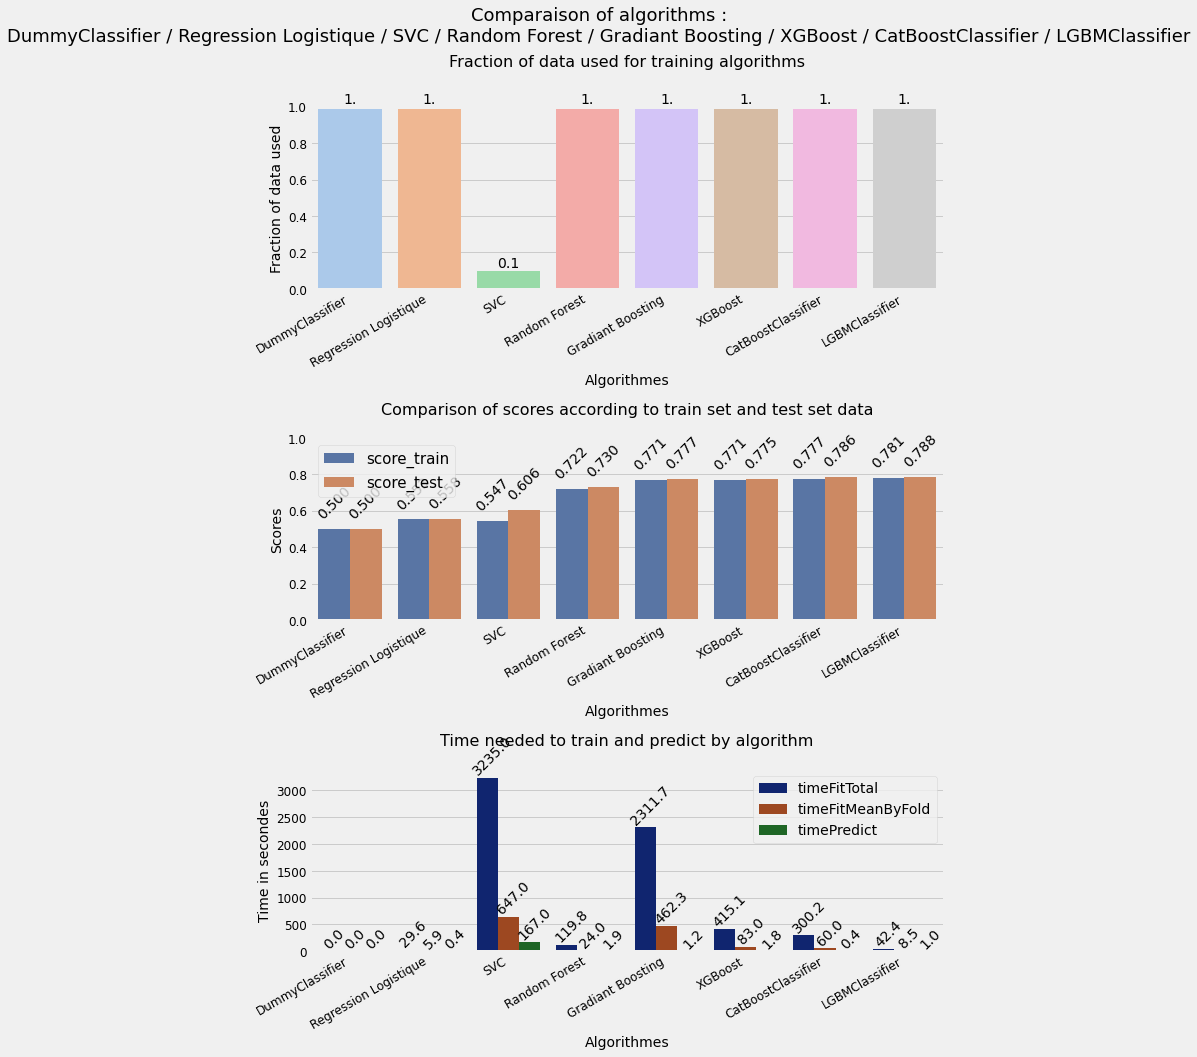

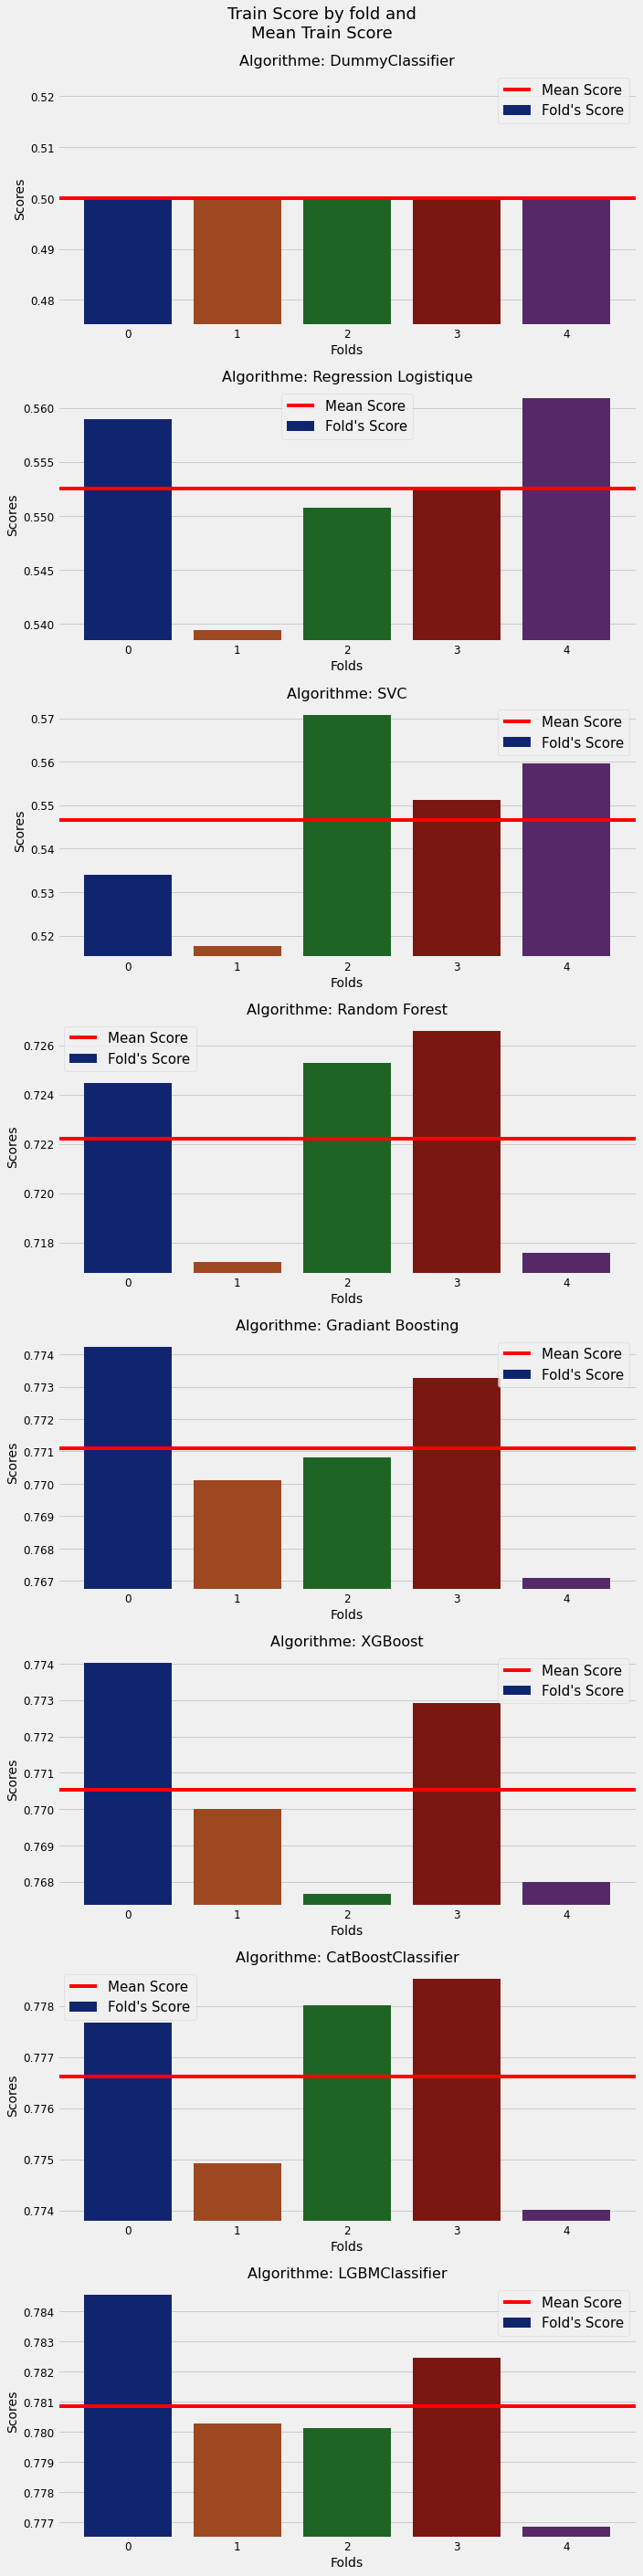

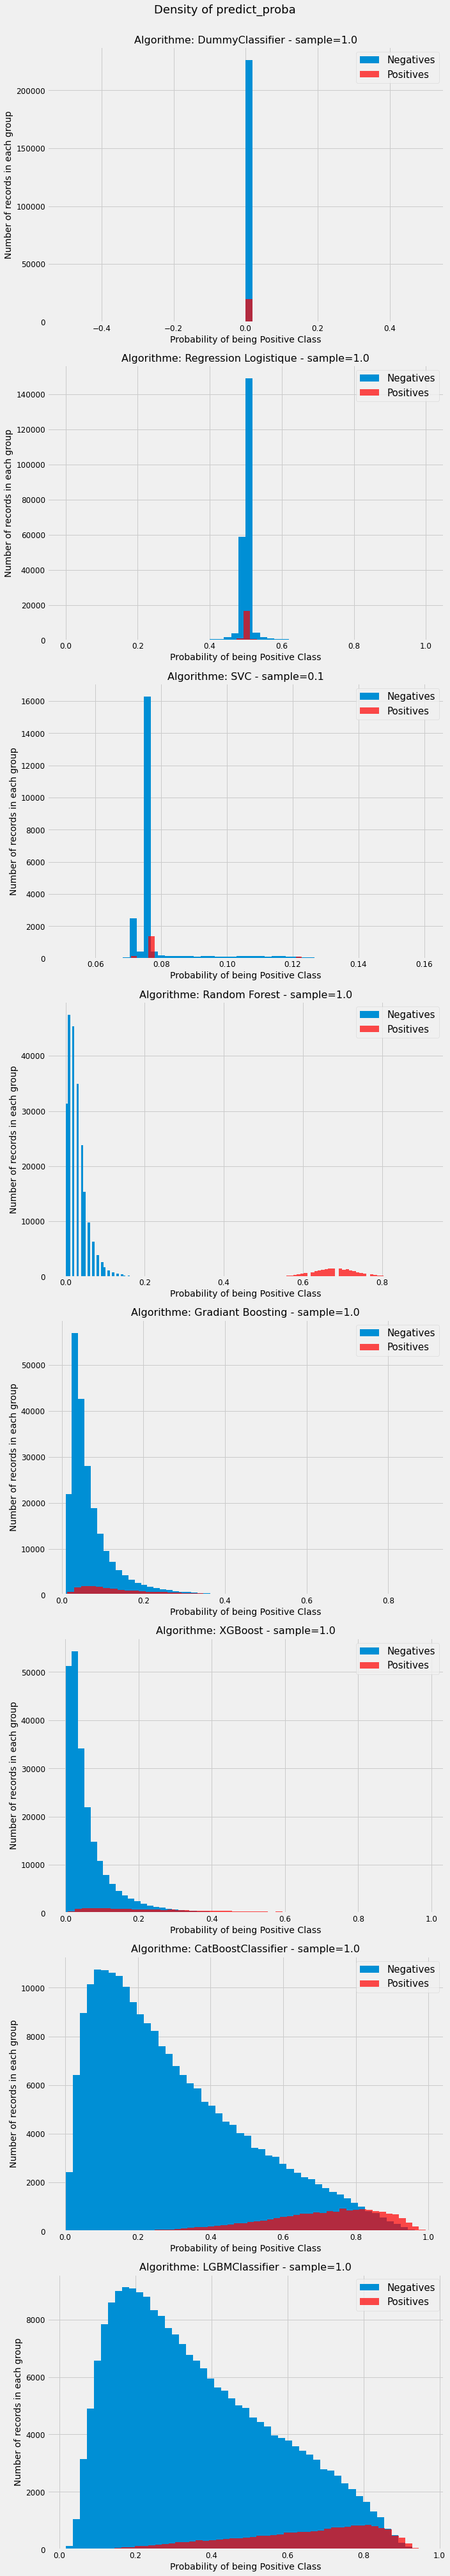

In [232]:
bestAlgo(
    data = df,
    dictAlgo = \
    {
        'DummyClassifier': None,
        'Regression Logistique': None,
        'SVC': None,
        'Random Forest': None,
        'Gradiant Boosting': None,
        'XGBoost': None,
        'CatBoostClassifier': None,
        'LGBMClassifier': None
    },
    listSample = [
        1,
        0.1,
        0.01,
        0.001
    ],
    cv = 5,
    showResult = True,
    lvlDebug = 2
)

In [229]:
@timeout(18000) # 5 hours maximum
def fitAlgo(dictData, algoName, sample):
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 4, startFunction = True)
    
    dictData[algoName].fit(dictData['TrainTest'][sample]['X_train'],
                       dictData['TrainTest'][sample]['y_train'])
    printDebug(level = 5, levelDebug = globalLevelDebug, indentation = 4, endFunction = True)
    return dictData

bestAlgo - Start
levelDebug = 3
	genDictAllDataTrainTest - Sample = 1 - classWeight = {0.0: 0.5436406387426688, 1.0: 6.228605428397812}
	evaluateAlgo - Start - LGBMClassifier
		nbFolds = 5
		evaluateAlgo - Boucle For - Start - sample = 1
		algoChoice - algo_params: {'boosting_type': 'gbdt', 'class_weight': {0.0: 0.5436406387426688, 1.0: 6.228605428397812}, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
		evaluateAlgo - Boucle For - End - sample = 1
		evaluateAlgo - Result - OK
	evaluateAlgo - End
	evaluateAlgo - Start - CatBoostClassifier
		nbFolds = 5
		evaluateAlgo - Boucle For - Start - sample = 1
		algoChoice - algo_params: {'verbose': False, 'class_weig

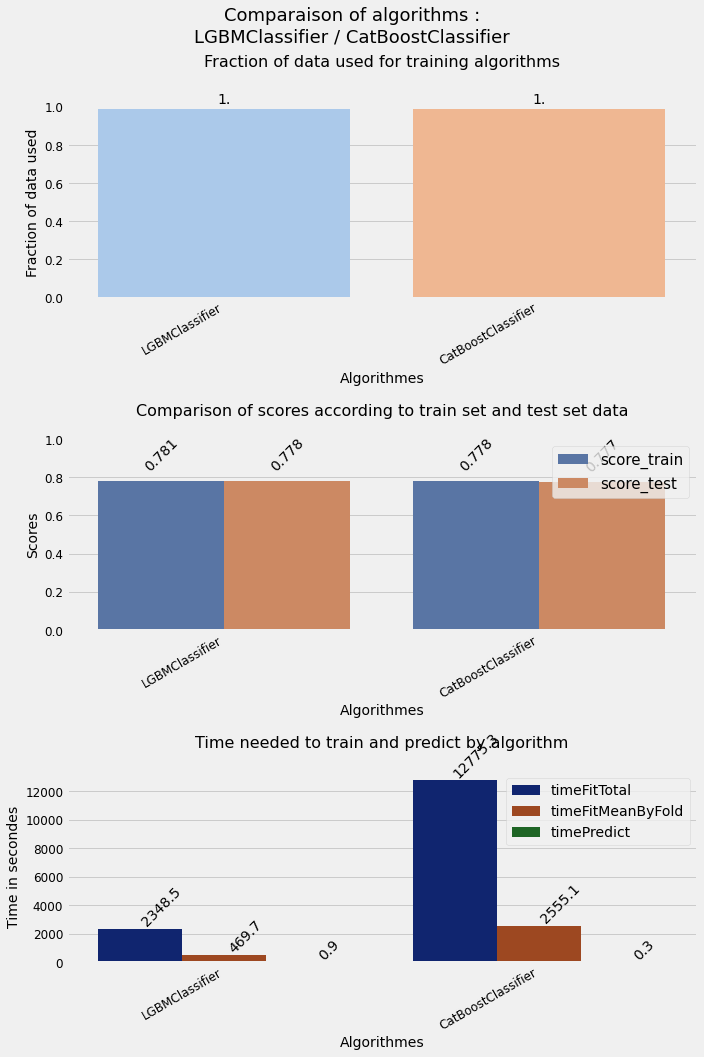

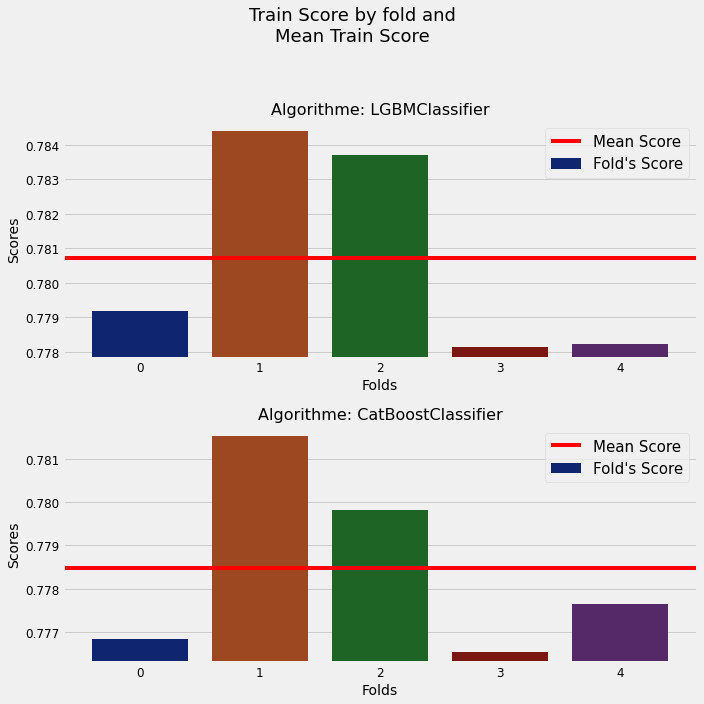

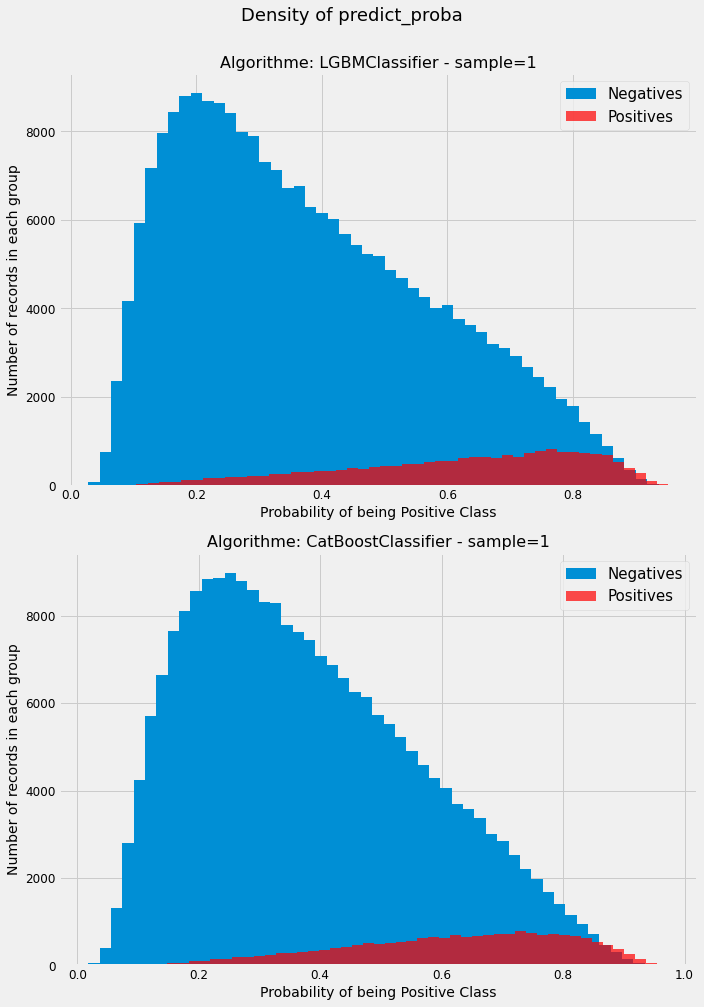

Fichier pickle enregistré: C:\Users\archi\Openclassrooms\pickle\dfResult_2022_08_19_18_00_48.pkl
Fichier pickle enregistré: C:\Users\archi\Openclassrooms\pickle\dictResult_2022_08_19_18_00_48.pkl
Fichier pickle enregistré: C:\Users\archi\Openclassrooms\pickle\dictData_2022_08_19_18_00_48.pkl


In [230]:
result, dictData = bestAlgo(
    data = df,
    dictAlgo = {'LGBMClassifier':
        {
            'learning_rate': [0.01, 0.1],
            'max_depth': [5, 15],
            'num_leaves': [8, 16],
            'boosting_type' : ['gbdt', 'dart'] # for better accuracy -> try dart
        },
        'CatBoostClassifier':
        {        
            'max_depth':[3, 8],
            'iterations':[500, 1000],
            'learning_rate':[0.01, 0.3], 
            'thread_count':[4]
        }
    },
    listSample = [
        1
    ],
    cv = 5,
    showResult = True,
    returnResult = True,
    returnData = True,
    toPickle = True,
    restartKernel = True,
    lvlDebug = 3
)

### VI.3.Définition du Seuil 

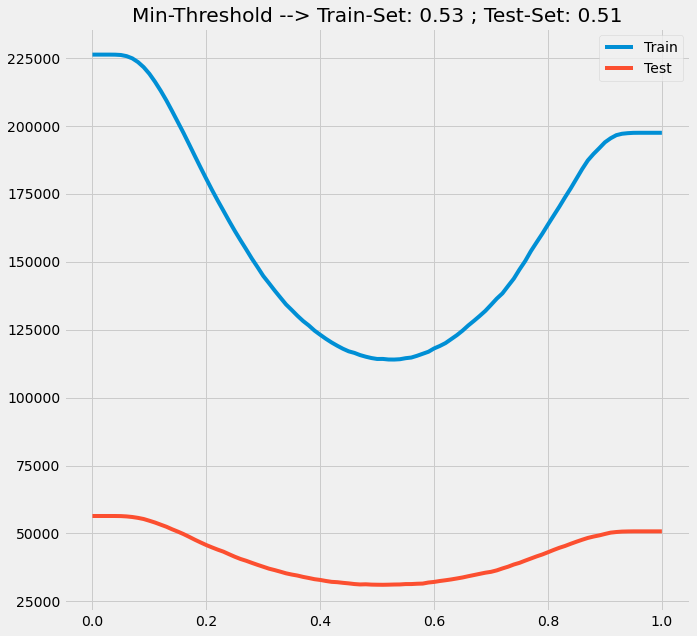

In [231]:
findBestThreshold(dictData, algo = 'LGBMClassifier', formula = '10 * fn + fp')